# Nutlin Comparison: TFEA, MD-Score, MDD-Score

This Jupyter notebook contains scripts to produce the figures associated with comparing the Nutlin response in HCT116 cells and MCF10A cells across MD-Score, MDD-Score and TFEA contained within the TFEA paper (Rubin et al. 2020)

# Table of Contents
1. [Initialize](#Initialize)<br>
2. [Main figure](#Main-figure)<br>
    2.1 [HCT116 Method Comparison](#HCT116-Method-Comparison)<br>
    2.2 [MCF10A Method Comparison](#MCF10A-Method-Comparison)<br>
    2.3 [HCT116 vs. MCF10A p53 Response Comparison](#HCT116-vs.-MCF10A-p53-response-Comparison)<br>
3. [Supplemental Figures](#Supplemental-Figures)<br>
    3.1[HCT116 p-value Thresholds](#HCT116-p-value-thresholds)<br>
    3.2[MCF10A p-value Thresholds](#MCF10A-p-value-thresholds)<br>
    3.3[Run FIMO for Subsequent Figures](#Run-Fimo-for-subsequent-supplemental-figures)<br>
    3.4[Supplemental Figure MD-Score](#Supplemental-Figure-MD-Score)<br>
    3.5[Supplemental Figure MDD-Score](#Supplemental-Figure-MDD-Score)<br>
    3.6[Supplemental Figure TFEA](#Supplemental-Figure-TFEA)<br>

## Initialize

Import required packages, define functions used later in the script. Note: Run this section twice for proper setting of figure font size

In [5]:
#Import necessary python packages
import os
import sys

sys.path.insert(0, "/Users/joru1876/.local/lib/python3.6/site-packages/") #Location of your installed python packages
os.environ['PATH'] = '/Users/joru1876/meme/bin:' + os.environ['PATH'] #Path to your meme installation

from matplotlib_venn import venn2
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.gridspec as gridspec
import numpy as np
from scipy import stats
import math
from pathlib import Path
from IPython.display import FileLink


###USER INPUTS###=====================================================
figuredir = Path('/Users/joru1876/TFEA_Jupyter/Figures/') #Figure save directory
filedir = Path('/Users/joru1876/TFEA_Jupyter/Nutlin_Comparison_Files') #Intermediate file save directory
#======================================================================

def read_results(results):
    result_list = []
    with open(results) as F:
        for line in F:
            if line[0] != '#':
                linelist = [float(l) if 'H11MO' not in l else l for l in line.strip().split('\t')]
                result_list.append(linelist)
    return result_list

def plot_global_gc(results, p_cutoff=None, title=None, xlabel=None, 
                        ylabel=None, savepath=None, dpi=100, x_index=None,
                        y_index=None, p_index=None, c_index=None, 
                        linear_regression=None, ylimits=None, 
                          ax=None):
    
    #Remove Nans from results
    clean_results = [i for i in results if i[y_index] == i[y_index] and i[x_index] == i[x_index]]
    ylist = [i[y_index] for i in clean_results]
    xlist = [i[x_index] for i in clean_results]
    clist = [i[c_index] for i in clean_results]
    max_c = abs(max([x for x in clist if x == x], key=abs))
    scatter = ax.scatter(xlist, ylist, edgecolor='', c=clist, s=50, cmap='viridis',
                            vmax=max_c, vmin=-max_c)
    cbar = plt.colorbar(scatter)
    cbar.set_label('GC-Content', rotation=270, labelpad=20)

    if p_index != None:
        plist = [i[p_index] for i in clean_results]
        sigx = [x for x,p in zip(xlist,plist) if p<p_cutoff]
        sigy = [y for y,p in zip(ylist,plist) if p<p_cutoff]
        sigc = [scatter.to_rgba(c) for c,p in zip(clist,plist) if p<p_cutoff]
        ax.scatter(sigx, sigy, c=sigc, #marker='x', 
                        edgecolor='r', linewidth=2, s=50)
    
    if linear_regression != None:
        slope, intercept, r_value, p_value, _ = linear_regression
        s = ("y = (" + str("%.3g" % slope) + ")x + " + str("%.3g" % intercept)
            + "\nR$^2$ = " + str("%.3g" % r_value**2)
            + "\np-val = " + str("%.3g" % p_value))
        ax.plot([0,1],[intercept, slope+intercept], color='r', alpha=0.5, label=s, 
                linewidth=5)

        ax.legend(loc='best')

    ax.axhline(0, linestyle='--', alpha=0.5, linewidth=2, c='k')
    ax.set_xlim([0,1])
    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.tick_params(axis='y', which='both', left=True, right=False, 
                    labelleft=True)

    ax.tick_params(axis='x', which='both', bottom=True, top=False, 
                    labelbottom=True)
    if ylimits != None:
        ax.set_ylim(ylimits)
        
def plot_global_MA(results, p_cutoff=None, title=None, xlabel=None, 
                    ylabel=None, x_index=None, y_index=None, c_index=None,
                    p_index=None, savepath=None, dpi=100, ylimits=None,
                      ax=None):
    '''Plot an MA plot. Note: x-values will be transformed to log10

    Parameters
    ----------
    results : list of lists
        contains calculated enrichment scores for all TFs of interest specified
        by the user
    '''
    clean_results = [i for i in results if i[y_index] == i[y_index] and i[x_index] == i[x_index]]
    ylist = [i[y_index] for i in clean_results]
    xlist = [math.log(i[x_index], 10) if i[x_index] != 0 else 0 for i in clean_results]
    if c_index != None:
        clist = [i[c_index] for i in clean_results]
        max_c = abs(max([x for x in clist if x == x], key=abs))
        # import sys
        # print("MA c-list:", clist, file=sys.stderr)
        # print("MA max_c:", max_c, file=sys.stderr)
        scatter = ax.scatter(xlist, ylist, edgecolor='', c=clist, s=50, cmap='viridis',
                                vmax=max_c, vmin=-max_c)
    else:
        scatter = ax.scatter(xlist, ylist, edgecolor='', color='navy', s=50)

    if p_index != None:
        plist = [i[p_index] for i in clean_results]
        sigx = [x for x,p in zip(xlist,plist) if p<p_cutoff]
        sigy = [y for y,p in zip(ylist,plist) if p<p_cutoff]
        if c_index != None:
            sigc = [scatter.to_rgba(c) for c,p in zip(clist,plist) if p<p_cutoff]
            ax.scatter(sigx, sigy, c='w', #marker='x', 
                        edgecolor='r',  linewidth=2, s=50, label=f'p < {p_cutoff}')
        else:
            ax.scatter(sigx, sigy, color='red', edgecolor='',  s=50, 
            label=f'p < {p_cutoff}')
        ax.legend(loc='best')

    ax.set_title(title, fontsize=14)
    ax.set_ylabel(ylabel, fontsize=14)
    ax.set_xlabel(xlabel, fontsize=14)
    ax.tick_params(axis='y', which='both', left=True, right=False, 
                    labelleft=True)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, 
                    labelbottom=True)
    if ylimits != None:
        ax.set_ylim(ylimits)
        
def plot_GC_histogram(TFEA_directory, hist1=None, hist2=None, label1=None, label2=None, ax=None):
    corrected_results = read_results(Path(TFEA_directory) / 'results.txt')
    uncorrected_results = [[corrected_results[i][1]-corrected_results[i][4]] + corrected_results[i] for i in range(len(corrected_results))]

    motif_gc_auc = [[uncorrected_results[i][1], uncorrected_results[i][0], uncorrected_results[i][4]] for i in range(len(uncorrected_results))]
    varx = np.array([i[2] for i in motif_gc_auc])
    vary = np.array([i[1] for i in motif_gc_auc])
    mask = ~np.isnan(varx) & ~np.isnan(vary)
    linear_regression = [x for x in stats.linregress(varx[mask], vary[mask])]
    
    slope, intercept, r_value, p_value, _ = linear_regression
    s = ("y = (" + str("%.3g" % slope) + ")x + " + str("%.3g" % intercept)
        + "\nR$^2$ = " + str("%.3g" % r_value**2)
        + "\np-val = " + str("%.3g" % p_value))
    
    
    histogram_data1 = [[float(x) for x in l.split('\t')] for l in hist1.read_text().split('\n')[:-1] if l[0] != '#']
    histogram_data2 = [[float(x) for x in l.split('\t')] for l in hist2.read_text().split('\n')[:-1] if l[0] != '#']
    
    ax.plot([x[0] for x in histogram_data1], [x[1]*100 for x in histogram_data1], label=label1, c='b')
    ax.plot([x[0] for x in histogram_data2], [x[1]*100 for x in histogram_data2], label=label2, c='r')
    
    line_dummy = ax.plot([0],[0], color='r', alpha=0.5, label=s, 
                            linewidth=5)
    ax.set_xlabel('GC-Content')
    ax.set_ylabel('% Reads')
    
    ax2 = ax.twinx()
    
    ax2.plot([0,100],[intercept, (slope+intercept)], color='r', alpha=0.5, label=s, 
            linewidth=5)
    ax2.set_ylim([-0.5,0.5])
    ax2.set_ylabel('AUC')
    ax.legend(loc='best', fontsize=12)
    line_dummy.pop(0).remove()
    
def plot_GC_scatterplot(TFEA_directory, results1=None, results2=None, label1=None, label2=None, ax=None):
    corrected_results = read_results(Path(TFEA_directory) / 'results.txt')
    uncorrected_results = [[corrected_results[i][1]-corrected_results[i][4]] + corrected_results[i] for i in range(len(corrected_results))]

    motif_gc_auc = [[uncorrected_results[i][1], uncorrected_results[i][0], uncorrected_results[i][4]] for i in range(len(uncorrected_results))]
    varx = np.array([i[2] for i in motif_gc_auc])
    vary = np.array([i[1] for i in motif_gc_auc])
    mask = ~np.isnan(varx) & ~np.isnan(vary)
    linear_regression = [x for x in stats.linregress(varx[mask], vary[mask])]
    
    slope, intercept, r_value, p_value, _ = linear_regression
    s = ("y = (" + str("%.3g" % slope) + ")x + " + str("%.3g" % intercept)
        + "\nR$^2$ = " + str("%.3g" % r_value**2)
        + "\np-val = " + str("%.3g" % p_value))
    
    
    scatter1 = [float(l.strip().strip('GC percentage = ').strip('%')) for l in results1.read_text().split('\n')[:-1] if 'GC percentage' in l]
    scatter2 = [float(l.strip().strip('GC percentage = ').strip('%')) for l in results2.read_text().split('\n')[:-1] if 'GC percentage' in l]
    
    ax.scatter([0], scatter1, label=label1, color='b', s=100)
    ax.scatter([1], scatter2, label=label2, color='r', s=100)
    plt.xticks([0,1], [label1, label2])
    
    line_dummy = ax.plot([0],[scatter1], color='r', alpha=0.5, label=s, 
                            linewidth=5)
    ax.set_ylabel('GC Percentage')
    ax.set_xlabel('GC Content')
    ax.set_ylim([50,60])
    
    ax2 = ax.twinx()
    
    ax2.plot([0,1],[intercept, (slope+intercept)], color='r', alpha=0.5, label=s, 
            linewidth=5)
    ax2.set_ylim([-0.5,0.5])
    ax2.set_ylabel('AUC')
    ax.legend(loc='best', fontsize=12)
    line_dummy.pop(0).remove()
    
def plot_dup_scatterplot(TFEA_directory, results1=None, results2=None, label1=None, label2=None, ax=None, ylim=None):
    corrected_results = read_results(Path(TFEA_directory) / 'results.txt')
    uncorrected_results = [[corrected_results[i][1]-corrected_results[i][4]] + corrected_results[i] for i in range(len(corrected_results))]

    motif_gc_auc = [[uncorrected_results[i][1], uncorrected_results[i][0], uncorrected_results[i][4]] for i in range(len(uncorrected_results))]
    varx = np.array([i[2] for i in motif_gc_auc])
    vary = np.array([i[1] for i in motif_gc_auc])
    mask = ~np.isnan(varx) & ~np.isnan(vary)
    linear_regression = [x for x in stats.linregress(varx[mask], vary[mask])]
    
    slope, intercept, r_value, p_value, _ = linear_regression
    s = ("y = (" + str("%.3g" % slope) + ")x + " + str("%.3g" % intercept)
        + "\nR$^2$ = " + str("%.3g" % r_value**2)
        + "\np-val = " + str("%.3g" % p_value))
    
    
    scatter1 = [float(l.strip().strip('duplication rate = ').strip('%')) for l in results1.read_text().split('\n')[:-1] if 'duplication rate' in l]
    scatter2 = [float(l.strip().strip('duplication rate = ').strip('%')) for l in results2.read_text().split('\n')[:-1] if 'duplication rate' in l]
    
    ax.scatter([0], scatter1, label=label1, color='b', s=100)
    ax.scatter([1], scatter2, label=label2, color='r', s=100)
    plt.xticks([0,1], [label1, label2])
    
    line_dummy = ax.plot([0],[scatter1], color='r', alpha=0.5, label=s, 
                            linewidth=5)
    ax.set_ylabel('Duplication Rate (%)')
    ax.set_xlabel('GC Content')
    ax.set_ylim(ylim)
    
    ax2 = ax.twinx()
    
    ax2.plot([0,1],[intercept, (slope+intercept)], color='r', alpha=0.5, label=s, 
            linewidth=5)
    ax2.set_ylim([-0.5,0.5])
    ax2.set_ylabel('AUC')
    ax.legend(loc='best', fontsize=12)
    line_dummy.pop(0).remove()
    
def plot_cov_scatterplot(TFEA_directory, results1=None, results2=None, label1=None, label2=None, ax=None, 
                            ylim=None):
    corrected_results = read_results(Path(TFEA_directory) / 'results.txt')
    uncorrected_results = [[corrected_results[i][1]-corrected_results[i][4]] + corrected_results[i] for i in range(len(corrected_results))]

    motif_gc_auc = [[uncorrected_results[i][1], uncorrected_results[i][0], uncorrected_results[i][4]] for i in range(len(uncorrected_results))]
    varx = np.array([i[2] for i in motif_gc_auc])
    vary = np.array([i[1] for i in motif_gc_auc])
    mask = ~np.isnan(varx) & ~np.isnan(vary)
    linear_regression = [x for x in stats.linregress(varx[mask], vary[mask])]
    
    slope, intercept, r_value, p_value, _ = linear_regression
    s = ("y = (" + str("%.3g" % slope) + ")x + " + str("%.3g" % intercept)
        + "\nR$^2$ = " + str("%.3g" % r_value**2)
        + "\np-val = " + str("%.3g" % p_value))
    
    
    meancov1 = [float(l.strip().strip('mean coverageData = ').strip('X')) for l in results1.read_text().split('\n')[:-1] if 'mean coverageData' in l][0]
    meancov2 = [float(l.strip().strip('mean coverageData = ').strip('X')) for l in results2.read_text().split('\n')[:-1] if 'mean coverageData' in l][0]
    
    stdcov1 = [float(l.strip().strip('std coverageData = ').strip('X')) for l in results1.read_text().split('\n')[:-1] if 'std coverageData' in l][0]
    stdcov2 = [float(l.strip().strip('std coverageData = ').strip('X')) for l in results2.read_text().split('\n')[:-1] if 'std coverageData' in l][0]

    
    ax.scatter([0], [meancov1], label=label1, color='b', s=100)
    
    ax.scatter([1], [meancov2], label=label2, color='r', s=100)
    
    plt.xticks([0,1], [label1, label2])
    
    line_dummy = ax.plot([0],[meancov1], color='r', alpha=0.5, label=s, 
                            linewidth=5)
    ax.set_ylabel('Mean Coverage (X)')
    ax.set_xlabel('GC Content')
    if ylim != None:
        ax.set_ylim(ylim)
    
    ax2 = ax.twinx()
    
    ax2.plot([0,1],[intercept, (slope+intercept)], color='r', alpha=0.5, label=s, 
            linewidth=5)
    ax2.set_ylim([-0.5,0.5])
    ax2.set_ylabel('AUC')
    ax.legend(loc='best', fontsize=12)
    line_dummy.pop(0).remove()

    

# Main figure

## HCT116 Method Comparison

/opt/jupyterhub/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/opt/jupyterhub/venv/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/opt/jupyterhub/venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


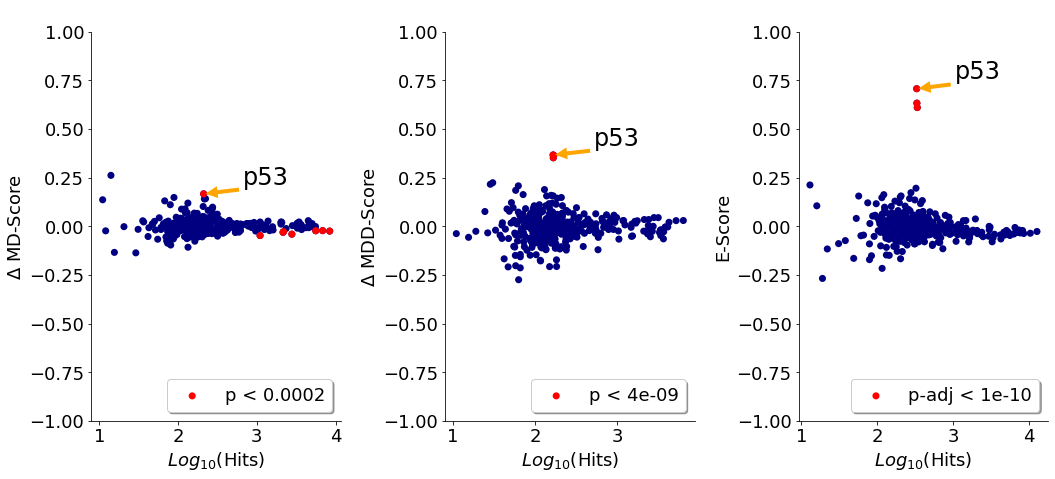

/Users/joru1876/TFEA_Jupyter/Figures/HCT116_Nutlin_MethodComparsion_pvariable.pdf

In [6]:
def plot_global_MA(results, p_cutoff=None, title=None, xlabel=None, 
                    ylabel=None, x_index=None, y_index=None, c_index=None,
                    p_index=None, savepath=None, dpi=100, ylimits=None,
                      ax=None, motif=None, multiply_by_2=False, padj=False):
    '''Plot an MA plot. Note: x-values will be transformed to log10

    Parameters
    ----------
    results : list of lists
        contains calculated enrichment scores for all TFs of interest specified
        by the user
    '''
    clean_results = [i for i in results if i[y_index] == i[y_index] and i[x_index] == i[x_index] and i[x_index] > 10]
    ylist = [i[y_index] for i in clean_results]
    if multiply_by_2:
        ylist = [y*2 for y in ylist]
    xlist = [math.log(i[x_index], 10) if i[x_index] != 0 else 0 for i in clean_results]
    scatter = ax.scatter(xlist, ylist, edgecolor='', color='navy', s=50)

    if p_index != None:
        plist = [i[p_index] for i in clean_results]
        sigx = [x for x,p in zip(xlist,plist) if p<p_cutoff]
        sigy = [y for y,p in zip(ylist,plist) if p<p_cutoff]
        if not padj:
            ax.scatter(sigx, sigy, color='red', edgecolor='',  s=50, 
                        label=f'p < {p_cutoff}')
        else:
            ax.scatter(sigx, sigy, color='red', edgecolor='',  s=50, 
                        label=f'p-adj < {p_cutoff}')
        ax.legend(loc='lower right', shadow=True)#frameon=False)
    
    if motif != None:
        motif_i = [i for i in range(len(clean_results)) if clean_results[i][0] == motif][0]
        x = xlist[motif_i]
        y = ylist[motif_i]
        ax.annotate('p53', (x, y), xytext=(x+0.5, y+0.05),fontsize=24, arrowprops=dict(facecolor='orange', linewidth=0,shrink=0.05))

    # ylist = [i[1] for i in results]
    # xlist = [math.log(i[2], 10) if i[2] != 0 else 0 for i in results]
    # plist = [i[-1] for i in results]

    # sigx = [x for x, p in zip(xlist, plist) if p < p_cutoff]
    # sigy = [y for y, p in zip(ylist, plist) if p < p_cutoff]

    # ax.scatter(xlist, ylist, color='navy', edgecolor='', s=50)
    # ax.scatter(sigx, sigy, color='red', edgecolor='', s=50)

    ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.tick_params(axis='y', which='both', left=True, right=False, 
                    labelleft=True)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, 
                    labelbottom=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ylimits != None:
        ax.set_ylim(ylimits)

#============================================================================================        

TFEA_results = read_results('/Users/joru1876/TFEA_files/Allen2014/v5_output/20191204_DMSO_Nutlin_bugfix/results.txt')
MD_results = read_results('/Users/joru1876/TFEA_files/Allen2014/v5_output/20191204_DMSO_Nutlin_bugfix/md_results.txt')
MDD_results = read_results('/Users/joru1876/TFEA_files/Allen2014/v5_output/20191204_DMSO_Nutlin_bugfix/mdd_results.txt')

p_cut = 1e-6

F = plt.figure(figsize=(15,7))
ax1 = F.add_subplot(133)
plot_global_MA(TFEA_results, p_cutoff=1e-10, title=" ", xlabel="$Log_{10}$(Hits)", 
                        ylabel="E-Score", savepath=None, dpi=100, x_index=3,
                        y_index=2, p_index=-1, ylimits=[-1, 1], motif='P53_HUMAN.H11MO.0.A',
                          ax=ax1, multiply_by_2=False, padj=True)
ax2 = F.add_subplot(131)
plot_global_MA(MD_results, p_cutoff=2e-4, title=" ", xlabel="$Log_{10}$(Hits)", 
                        ylabel="$\Delta$ MD-Score", savepath=None, dpi=100, x_index=2,
                        y_index=1, p_index=-1, ylimits=[-1, 1], motif='P53_HUMAN.H11MO.0.A',
                          ax=ax2)

ax3 = F.add_subplot(132)
plot_global_MA(MDD_results, p_cutoff=4e-9, title=" ", xlabel="$Log_{10}$(Hits)", 
                    ylabel="$\Delta$ MDD-Score", x_index=2, y_index=1, c_index=5,
                    p_index=-1, savepath=None, dpi=100, ylimits=[-1, 1],motif='P53_HUMAN.H11MO.0.A',
                      ax=ax3)
plt.tight_layout()
figname = os.path.join(figuredir, f'HCT116_Nutlin_MethodComparsion_pvariable.pdf')
F.savefig(figname)
plt.show()
FileLink(str(Path(figname).relative_to(Path.cwd())))

## MCF10A Method Comparison

/opt/jupyterhub/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/opt/jupyterhub/venv/lib/python3.6/site-packages/ipykernel_launcher.py:29: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/opt/jupyterhub/venv/lib/python3.6/site-packages/ipykernel_launcher.py:26: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


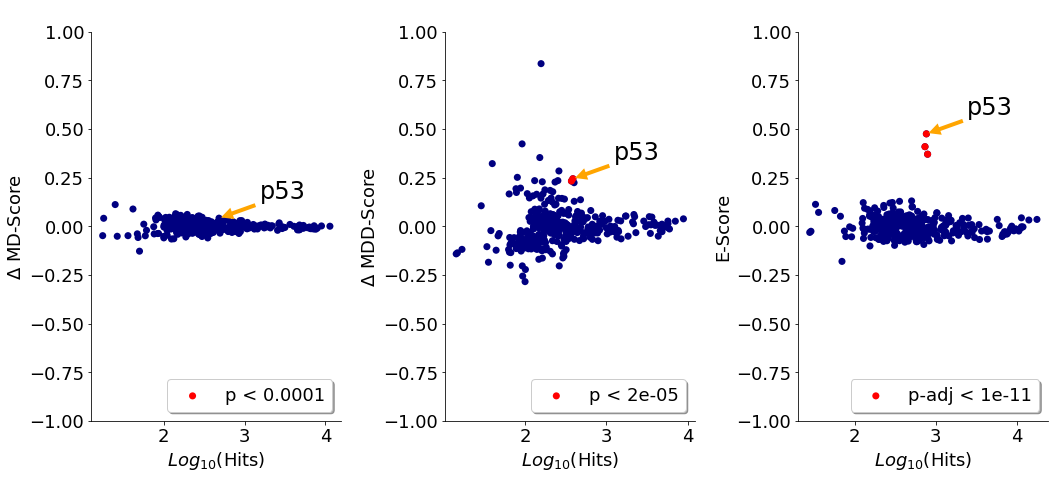

/Users/joru1876/TFEA_Jupyter/Figures/MCF10A_Nutlin_MethodComparsion_pvariable.pdf

In [7]:
def plot_global_MA(results, p_cutoff=None, title=None, xlabel=None, 
                    ylabel=None, x_index=None, y_index=None, c_index=None,
                    p_index=None, savepath=None, dpi=100, ylimits=None,
                      ax=None, motif=None, multiply_by_2=False, padj=False):
    '''Plot an MA plot. Note: x-values will be transformed to log10

    Parameters
    ----------
    results : list of lists
        contains calculated enrichment scores for all TFs of interest specified
        by the user
    '''
    clean_results = [i for i in results if i[y_index] == i[y_index] and i[x_index] == i[x_index] and i[x_index] > 10]
    ylist = [i[y_index] for i in clean_results]
    if multiply_by_2:
        ylist = [y*2 for y in ylist]
    xlist = [math.log(i[x_index], 10) if i[x_index] != 0 else 0 for i in clean_results]
    scatter = ax.scatter(xlist, ylist, edgecolor='', color='navy', s=50)

    if p_index != None:
        plist = [i[p_index] for i in clean_results]
        sigx = [x for x,p in zip(xlist,plist) if p<p_cutoff]
        sigy = [y for y,p in zip(ylist,plist) if p<p_cutoff]
        if not padj:
            ax.scatter(sigx, sigy, color='red', edgecolor='',  s=50, 
                        label=f'p < {p_cutoff}')
        else:
            ax.scatter(sigx, sigy, color='red', edgecolor='',  s=50, 
                        label=f'p-adj < {p_cutoff}')
        ax.legend(loc='lower right', shadow=True)#frameon=False)
    
    if motif != None:
        motif_i = [i for i in range(len(clean_results)) if clean_results[i][0] == motif][0]
        x = xlist[motif_i]
        y = ylist[motif_i]
        ax.annotate('p53', (x, y), xytext=(x+0.5, y+0.1),fontsize=24, arrowprops=dict(facecolor='orange', linewidth=0,shrink=0.05))

    # ylist = [i[1] for i in results]
    # xlist = [math.log(i[2], 10) if i[2] != 0 else 0 for i in results]
    # plist = [i[-1] for i in results]

    # sigx = [x for x, p in zip(xlist, plist) if p < p_cutoff]
    # sigy = [y for y, p in zip(ylist, plist) if p < p_cutoff]

    # ax.scatter(xlist, ylist, color='navy', edgecolor='', s=50)
    # ax.scatter(sigx, sigy, color='red', edgecolor='', s=50)

    ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.tick_params(axis='y', which='both', left=True, right=False, 
                    labelleft=True)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, 
                    labelbottom=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ylimits != None:
        ax.set_ylim(ylimits)

#============================================================================================        

TFEA_results = read_results('/Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/results.txt')
MD_results = read_results('/Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/md_results.txt')
MDD_results = read_results('/Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/mdd_results.txt')

p_cut = 1e-6

F = plt.figure(figsize=(15,7))
ax1 = F.add_subplot(133)
plot_global_MA(TFEA_results, p_cutoff=1e-11, title=' ', xlabel="$Log_{10}$(Hits)", 
                        ylabel="E-Score", savepath=None, dpi=100, x_index=3,
                        y_index=2, p_index=-1, ylimits=[-1, 1], motif='P53_HUMAN.H11MO.0.A',
                          ax=ax1, multiply_by_2=False, padj=True)
ax2 = F.add_subplot(131)
plot_global_MA(MD_results, p_cutoff=1e-4, title=' ', xlabel="$Log_{10}$(Hits)", 
                        ylabel="$\Delta$ MD-Score", savepath=None, dpi=100, x_index=2,
                        y_index=1, p_index=-1, ylimits=[-1, 1], motif='P53_HUMAN.H11MO.0.A',
                          ax=ax2)

ax3 = F.add_subplot(132)
plot_global_MA(MDD_results, p_cutoff=2e-5, title=' ', xlabel="$Log_{10}$(Hits)", 
                    ylabel="$\Delta$ MDD-Score", x_index=2, y_index=1, c_index=5,
                    p_index=-1, savepath=None, dpi=100, ylimits=[-1, 1],motif='P53_HUMAN.H11MO.0.A',
                      ax=ax3)
plt.tight_layout()
figname = os.path.join(figuredir, f'MCF10A_Nutlin_MethodComparsion_pvariable.pdf')
F.savefig(figname)
plt.show()
FileLink(str(Path(figname).relative_to(Path.cwd())))

## HCT116 vs. MCF10A p53 response Comparison

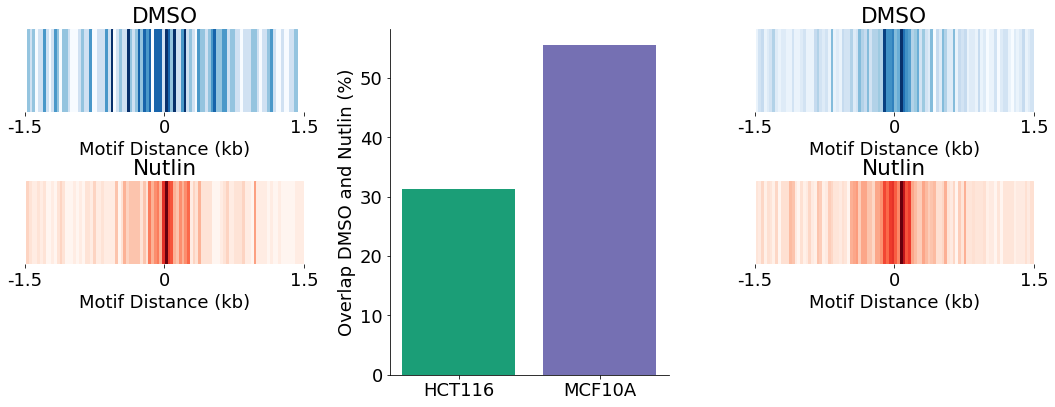

/Users/joru1876/TFEA_Jupyter/Figures/Nutlin_Bar_Heatmaps.pdf

In [8]:
def heatmap(distances, ax=None, xlim=None, bins=None, title=None, 
            largewindow=None, cmap='', smallwindow=150):
    counts, edges = np.histogram(distances, bins=bins)
    edges = (edges[1:]+edges[:-1])/2.0
    norm    = matplotlib.colors.Normalize(vmin=min(counts), 
                                            vmax=max(counts))
    if cmap == 'blues':
        cmap    = cm.Blues
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'oranges':
        cmap    = cm.Oranges
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'reds':
        cmap    = cm.Reds
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'greens':
        cmap    = cm.Greens
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    
    ax.bar(edges,np.ones((len(edges),)), color=colors, 
                width=(edges[-1]-edges[0])/len(edges), edgecolor=colors)
    ax.set_ylim([0,1])
    ax.set_xlim([-largewindow, largewindow])
#     ax.axvline(-smallwindow, linestyle='--', c='k', alpha=0.5)
#     ax.axvline(smallwindow, linestyle='--', c='k', alpha=0.5)
    ax.tick_params(axis='y', which='both', left=False, right=False, 
                    labelleft=False) 
    ax.tick_params(axis='x', which='both', bottom=True, top=False, 
                    labelbottom=True)
    ax.set_xlabel('Motif Distance (kb)')
    ax.set_xticks([-largewindow, 0, largewindow])
    ax.set_xticklabels([str(-largewindow/1000), 0, str(largewindow/1000)])
    if title is not None:
        ax.set_title(title, fontsize=18)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    return

def bar_venn(venn, ax=None):
    ax.axis(False)
    ax.text(venn[0]/2, 0, str(venn[0]))
    ax.barh(0, venn[0], color='blue', alpha=0.6, edgecolor='')
    ax.text(np.mean([venn[0]]*2 + [venn[2]]), 0, str(venn[2]))
    ax.barh(0, venn[2], left=venn[0], color='peachpuff', alpha=1.0, edgecolor='')
    ax.text(np.mean([venn[0]] + [venn[2]] + venn), 0, str(venn[1]))
    ax.barh(0, venn[1], left=venn[0]+venn[2], color='red', alpha=0.8, edgecolor='')
    ax.set_xlim([0, np.sum(venn)])
    ax.set_ylim([0,2])
    return
    

def parse_fimo_venn(fimo_res1, fimo_res2):
    overlap1 = []
    overlap2 = []
    intersect = []
    heatmap1 = {}
    heatmap2 = {}
    venn = [0 for i in range(3)]

    for line1 in fimo_res1[2:]:
        line1_list = line1.split('\t')
        region1 = line1_list[2]
        start1,stop1 = region1.split(':')[1].split('-')
        start1,stop1 = int(start1),int(stop1)
        score1 = float(line1_list[6])
        motif1_distance = np.mean([int(line1_list[3]), int(line1_list[4])]) - largewindow
        if region1 not in heatmap1:
            heatmap1[region1] = [score1, motif1_distance]
        elif score1 > heatmap1[region1][0]:
            heatmap1[region1] = [score1, motif1_distance]
            
    for line2 in fimo_res2[2:]:
        line2_list = line2.split('\t')
        region2 = line2_list[2]
        start2,stop2 = region2.split(':')[1].split('-')
        start2,stop2 = int(start2),int(stop2)
        score2 = float(line2_list[6])
        motif = int(start2) + np.mean([int(line2_list[3]), int(line2_list[4])])
        motif2_distance = np.mean([int(line2_list[3]), int(line2_list[4])]) - largewindow
        if region2 not in heatmap2:
            heatmap2[region2] = [score2, motif2_distance]
        elif score2 > heatmap2[region2][0]:
            heatmap2[region2] = [score2, motif2_distance]
            
            
    for region1 in heatmap1:
        chrom1 = region1.split(':')[0]
        start1,stop1 = region1.split(':')[1].split('-')
        start1,stop1 = int(start1),int(stop1)
        motif1_distance = heatmap1[region1]
        for region2 in heatmap2:
            chrom2 = region2.split(':')[0]
            start2,stop2 = region2.split(':')[1].split('-')
            start2,stop2 = int(start2),int(stop2)
            motif2_distance = heatmap2[region2]
            if chrom1 == chrom2 and (start1 <= start2 <= stop1 or start1 <= stop2 <= stop1):
                if abs(motif1_distance[1]) < 150 or abs(motif2_distance[1]) < 150:
                    overlap1.append(region1)
                    overlap2.append(region2)
                    #muMerge here?
                    i_start = min(start1, start2)
                    i_stop = max(stop1, stop2)
                    i_mid = np.mean([i_start, i_stop])
                    i_motif_distance = motif - i_mid
    #                 intersect.append(i_motif_distance)

#     heatmap1 = [d for i,d in enumerate(heatmap1) if i not in overlap1]
#     heatmap2 = [d for i,d in enumerate(heatmap2) if i not in overlap2]
    overlap1 = list(set(overlap1))
    overlap2 = list(set(overlap2))
    venn[2] = max(len(overlap1), len(overlap2))
    venn[0] = len([region for region in heatmap1 if region not in overlap1 and abs(heatmap1[region][1]) < 150])
    venn[1] = len([region for region in heatmap2 if region not in overlap2 and abs(heatmap2[region][1]) < 150])
    
    return [v[1] for v in heatmap1.values()], [v[1] for v in heatmap2.values()], venn


#=============================================================

largewindow = 1500

Allen_heatmap1, Allen_heatmap2, Allen_venn = parse_fimo_venn(Allen_md1_fimo, Allen_md2_fimo)
Levandowski_heatmap1, Levandowski_heatmap2, Levandowski_venn = parse_fimo_venn(Levandowski_md1_fimo, Levandowski_md2_fimo)

# Allen_intersect_len = max(Allen_overlap1, Allen_overlap2)

# Levandowski_intersect_len = max(Levandowski_overlap1, Levandowski_overlap2)

F = plt.figure(figsize=(15,6))
outer = gridspec.GridSpec(1, 3, width_ratios=[1,1,1])

#Heatmaps to the left
inner1 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer[0], height_ratios=[2,2,1], hspace=1)
ax1 = F.add_subplot(inner1[0])
ax1.set_title('DMSO')
heatmap(Allen_heatmap1, ax=ax1, largewindow=largewindow, bins=100, cmap='blues')
ax2 = F.add_subplot(inner1[1])
ax2.set_title('Nutlin')
heatmap(Allen_heatmap2, ax=ax2, largewindow=largewindow, bins=100, cmap='reds')

#Middle bar graph
ax3 = F.add_subplot(outer[0,1])
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)
ax3.bar([1,2],[100*Allen_venn[2]/sum(Allen_venn), 100*Levandowski_venn[2]/sum(Levandowski_venn)], 
       tick_label=['HCT116','MCF10A'], color=['#1b9e77','#7570b3'])
ax3.set_ylabel("Overlap DMSO and Nutlin (%)")

#Heatmaps to the right

inner2 = gridspec.GridSpecFromSubplotSpec(3, 1, subplot_spec=outer[2], height_ratios=[2,2,1], hspace=1)
ax3 = F.add_subplot(inner2[0])
heatmap(Levandowski_heatmap1, ax=ax3, largewindow=largewindow, bins=100, cmap='blues')
ax3.set_title('DMSO')
ax4 = F.add_subplot(inner2[1])
heatmap(Levandowski_heatmap2, ax=ax4, largewindow=largewindow, bins=100, cmap='reds')
ax4.set_title('Nutlin')

outer.tight_layout(F)
figname = os.path.join(figuredir, 'Nutlin_Bar_Heatmaps.pdf')
F.savefig(figname, bbox_inches='tight', format='pdf')
plt.show()
FileLink(str(Path(figname).relative_to(Path.cwd())))

# Supplemental Figures

## HCT116 p-value thresholds

/opt/jupyterhub/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


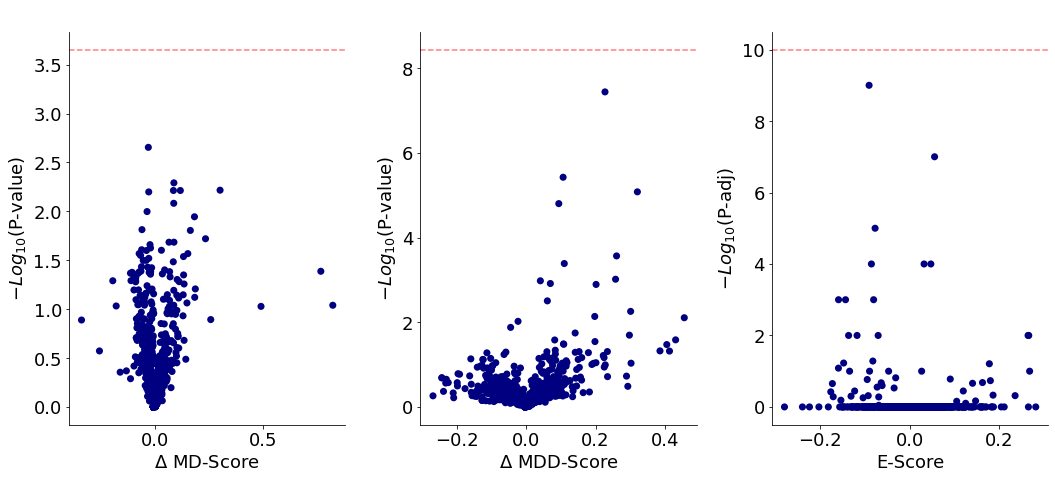

/Users/joru1876/TFEA_Jupyter/Figures/Supp_HCT116_Nutlin_MethodComparsion_pvaloptimize.pdf

In [9]:
def plot_global_volcano(results, p_cutoff=None, title=None, xlabel=None, 
                    ylabel=None, x_index=None, y_index=None, c_index=None,
                    p_index=None, savepath=None, dpi=100, ylimits=None,
                      ax=None, motif=None, multiply_by_2=False, padj=False):
    '''Plot an MA plot. Note: x-values will be transformed to log10

    Parameters
    ----------
    results : list of lists
        contains calculated enrichment scores for all TFs of interest specified
        by the user
    '''
    clean_results = [i for i in results if i[y_index] == i[y_index] and i[x_index] == i[x_index]]
    xlist = [i[x_index] for i in clean_results]
    ylist = [-math.log(i[y_index], 10) if i[y_index] != 0 else 0 for i in clean_results]
    if multiply_by_2:
        ylist = [y*2 for y in ylist]
    scatter = ax.scatter(xlist, ylist, edgecolor='', color='navy', s=50)
    ax.axhline(max(ylist) + 1, linestyle='--', c='r', alpha=0.5)
    if p_index != None:
        plist = [i[p_index] for i in clean_results]
        sigx = [x for x,p in zip(xlist,plist) if p<p_cutoff]
        sigy = [y for y,p in zip(ylist,plist) if p<p_cutoff]
        if not padj:
            ax.scatter(sigx, sigy, color='red', edgecolor='',  s=50, 
                        label=f'p < {p_cutoff}')
        else:
            ax.scatter(sigx, sigy, color='red', edgecolor='',  s=50, 
                        label=f'p-adj < {p_cutoff}')
        ax.legend(loc='lower right', shadow=True)#frameon=False)
    
    if motif != None:
        motif_i = [i for i in range(len(clean_results)) if clean_results[i][0] == motif][0]
        x = xlist[motif_i]
        y = ylist[motif_i]
        ax.annotate('p53', (x, y), xytext=(x+0.5, y+0.05),fontsize=24, arrowprops=dict(facecolor='orange', linewidth=0,shrink=0.05))

    ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.tick_params(axis='y', which='both', left=True, right=False, 
                    labelleft=True)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, 
                    labelbottom=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ylimits != None:
        ax.set_ylim(ylimits)

#============================================================================================        

TFEA_results = read_results('/Users/joru1876/TFEA_files/Allen2014/v5_output/20191211_DMSO1_DMSO2/results.txt')
MD_results = read_results('/Users/joru1876/TFEA_files/Allen2014/v5_output/20191211_DMSO1_DMSO2/md_results.txt')
MDD_results = read_results('/Users/joru1876/TFEA_files/Allen2014/v5_output/20191211_DMSO1_DMSO2/mdd_results.txt')

p_cut = 1e-6

F = plt.figure(figsize=(15,7))
ax1 = F.add_subplot(133)
plot_global_volcano(TFEA_results, title=" ", xlabel="E-Score", 
                        ylabel="$-Log_{10}$(P-adj)", x_index=2, y_index=-1, ax=ax1)

ax2 = F.add_subplot(131)
plot_global_volcano(MD_results, title=" ", xlabel="$\Delta$ MD-Score", 
                        ylabel="$-Log_{10}$(P-value)", savepath=None, dpi=100, x_index=1,
                        y_index=-1, ax=ax2)

ax3 = F.add_subplot(132)
plot_global_volcano(MDD_results, title=" ", xlabel="$\Delta$ MDD-Score", 
                        ylabel="$-Log_{10}$(P-value)", savepath=None, dpi=100, x_index=1,
                        y_index=-1, ax=ax3)

plt.tight_layout()
figname = os.path.join(figuredir, f'Supp_HCT116_Nutlin_MethodComparsion_pvaloptimize.pdf')
F.savefig(figname)
plt.show()
FileLink(str(Path(figname).relative_to(Path.cwd())))

## MCF10A p-value thresholds

/opt/jupyterhub/venv/lib/python3.6/site-packages/ipykernel_launcher.py:18: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


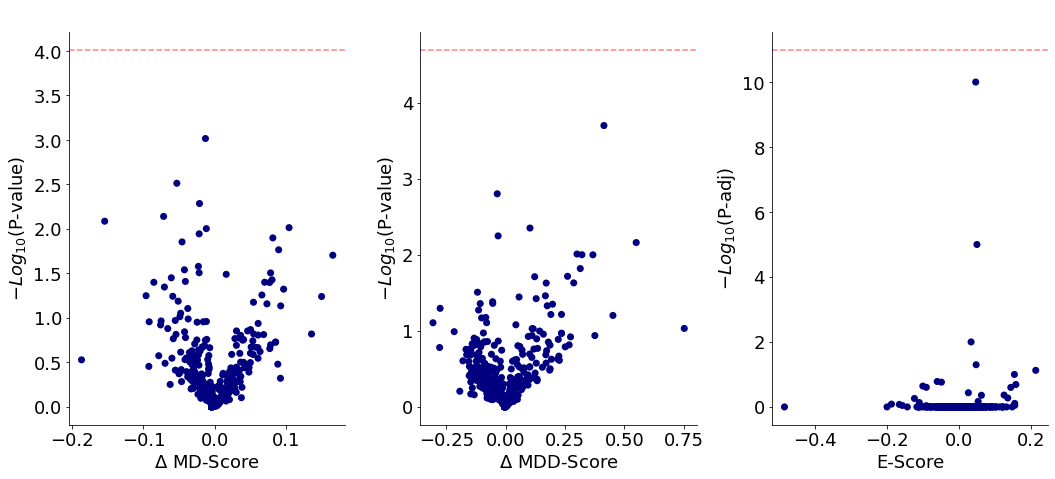

/Users/joru1876/TFEA_Jupyter/Figures/Supp_MCF10A_Nutlin_MethodComparsion_pvaloptimize.pdf

In [10]:
def plot_global_volcano(results, p_cutoff=None, title=None, xlabel=None, 
                    ylabel=None, x_index=None, y_index=None, c_index=None,
                    p_index=None, savepath=None, dpi=100, ylimits=None,
                      ax=None, motif=None, multiply_by_2=False, padj=False):
    '''Plot an MA plot. Note: x-values will be transformed to log10

    Parameters
    ----------
    results : list of lists
        contains calculated enrichment scores for all TFs of interest specified
        by the user
    '''
    clean_results = [i for i in results if i[y_index] == i[y_index] and i[x_index] == i[x_index]]
    xlist = [i[x_index] for i in clean_results]
    ylist = [-math.log(i[y_index], 10) if i[y_index] != 0 else 0 for i in clean_results]
    if multiply_by_2:
        ylist = [y*2 for y in ylist]
    scatter = ax.scatter(xlist, ylist, edgecolor='', color='navy', s=50)
    ax.axhline(max(ylist) + 1, linestyle='--', c='r', alpha=0.5)
    if p_index != None:
        plist = [i[p_index] for i in clean_results]
        sigx = [x for x,p in zip(xlist,plist) if p<p_cutoff]
        sigy = [y for y,p in zip(ylist,plist) if p<p_cutoff]
        if not padj:
            ax.scatter(sigx, sigy, color='red', edgecolor='',  s=50, 
                        label=f'p < {p_cutoff}')
        else:
            ax.scatter(sigx, sigy, color='red', edgecolor='',  s=50, 
                        label=f'p-adj < {p_cutoff}')
        ax.legend(loc='lower right', shadow=True)#frameon=False)
    
    if motif != None:
        motif_i = [i for i in range(len(clean_results)) if clean_results[i][0] == motif][0]
        x = xlist[motif_i]
        y = ylist[motif_i]
        ax.annotate('p53', (x, y), xytext=(x+0.5, y+0.05),fontsize=24, arrowprops=dict(facecolor='orange', linewidth=0,shrink=0.05))

    ax.set_title(title, fontsize=24)
    ax.set_ylabel(ylabel, fontsize=18)
    ax.set_xlabel(xlabel, fontsize=18)
    ax.tick_params(axis='y', which='both', left=True, right=False, 
                    labelleft=True)
    ax.tick_params(axis='x', which='both', bottom=True, top=False, 
                    labelbottom=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    if ylimits != None:
        ax.set_ylim(ylimits)

#============================================================================================        

TFEA_results = read_results('/Users/joru1876/TFEA_files/CECIE/7_WT_DMSO1_DMSO2_1hr_mumerge/results.txt')
MD_results = read_results('/Users/joru1876/TFEA_files/CECIE/7_WT_DMSO1_DMSO2_1hr_mumerge/md_results.txt')
MDD_results = read_results('/Users/joru1876/TFEA_files/CECIE/7_WT_DMSO1_DMSO2_1hr_mumerge/mdd_results.txt')

p_cut = 1e-6

F = plt.figure(figsize=(15,7))
ax1 = F.add_subplot(133)
plot_global_volcano(TFEA_results, title=" ", xlabel="E-Score", 
                        ylabel="$-Log_{10}$(P-adj)", x_index=2, y_index=-1, ax=ax1)

ax2 = F.add_subplot(131)
plot_global_volcano(MD_results, title=" ", xlabel="$\Delta$ MD-Score", 
                        ylabel="$-Log_{10}$(P-value)", savepath=None, dpi=100, x_index=1,
                        y_index=-1, ax=ax2)

ax3 = F.add_subplot(132)
plot_global_volcano(MDD_results, title=" ", xlabel="$\Delta$ MDD-Score", 
                        ylabel="$-Log_{10}$(P-value)", savepath=None, dpi=100, x_index=1,
                        y_index=-1, ax=ax3)

plt.tight_layout()
figname = os.path.join(figuredir, f'Supp_MCF10A_Nutlin_MethodComparsion_pvaloptimize.pdf')
F.savefig(figname)
plt.show()
FileLink(str(Path(figname).relative_to(Path.cwd())))

## Run Fimo for subsequent supplemental figures

In [11]:
Allen_md1_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/Allen2014/v5_output/20191204_DMSO_Nutlin_bugfix/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/Allen2014/v5_output/20191204_DMSO_Nutlin_bugfix/temp_files/md1_fasta.fa
Allen_md2_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/Allen2014/v5_output/20191204_DMSO_Nutlin_bugfix/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/Allen2014/v5_output/20191204_DMSO_Nutlin_bugfix/temp_files/md2_fasta.fa

Allen_dmso_oldrep1_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO1_Nutlin1_mumerge/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO1_Nutlin1_mumerge_oldhg19/temp_files/md1_fasta.fa
Allen_nutlin_oldrep1_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO1_Nutlin1_mumerge/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO1_Nutlin1_mumerge_oldhg19/temp_files/md2_fasta.fa

Allen_dmso_oldrep2_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO2_Nutlin2_mumerge/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO2_Nutlin2_mumerge_oldhg19/temp_files/md1_fasta.fa
Allen_nutlin_oldrep2_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO2_Nutlin2_mumerge/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO2_Nutlin2_mumerge_oldhg19/temp_files/md2_fasta.fa

Allen_dmso_oldcombined_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/Allen2014/v5_output/20191114_DMSO_Nutlin_mumerge/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/Allen2014/v5_output/20191114_DMSO_Nutlin_mumerge_oldhg19/temp_files/md1_fasta.fa
Allen_nutlin_oldcombined_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/Allen2014/v5_output/20191114_DMSO_Nutlin_mumerge/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/Allen2014/v5_output/20191114_DMSO_Nutlin_mumerge_oldhg19/temp_files/md2_fasta.fa

Allen_dmso_newrep1_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO1_Nutlin1_mumerge/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO1_Nutlin1_mumerge/temp_files/md1_fasta.fa
Allen_nutlin_newrep1_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO1_Nutlin1_mumerge/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO1_Nutlin1_mumerge/temp_files/md2_fasta.fa

Allen_dmso_newrep2_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO2_Nutlin2_mumerge/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO2_Nutlin2_mumerge/temp_files/md1_fasta.fa
Allen_nutlin_newrep2_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO2_Nutlin2_mumerge/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/Allen2014/v5_output/20191112_DMSO2_Nutlin2_mumerge/temp_files/md2_fasta.fa

Levandowski_md1_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/md1_fasta.fa
Levandowski_md2_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/md2_fasta.fa

Allen_combined_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/Allen2014/v5_output/20191204_DMSO_Nutlin_bugfix/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/Allen2014/v5_output/20191204_DMSO_Nutlin_bugfix/temp_files/ranked_file.fa
Levandowski_combined_fimo = !fimo --skip-matched-sequence --verbosity 1 --thresh 1e-6 --bgfile /Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/markov_background.txt --motif P53_HUMAN.H11MO.0.A /scratch/Users/joru1876/TFEA/motif_files/HOCOMOCOv11_core_HUMAN_mono_meme_format.meme /Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/ranked_file.fa



## Supplemental Figure MD-Score

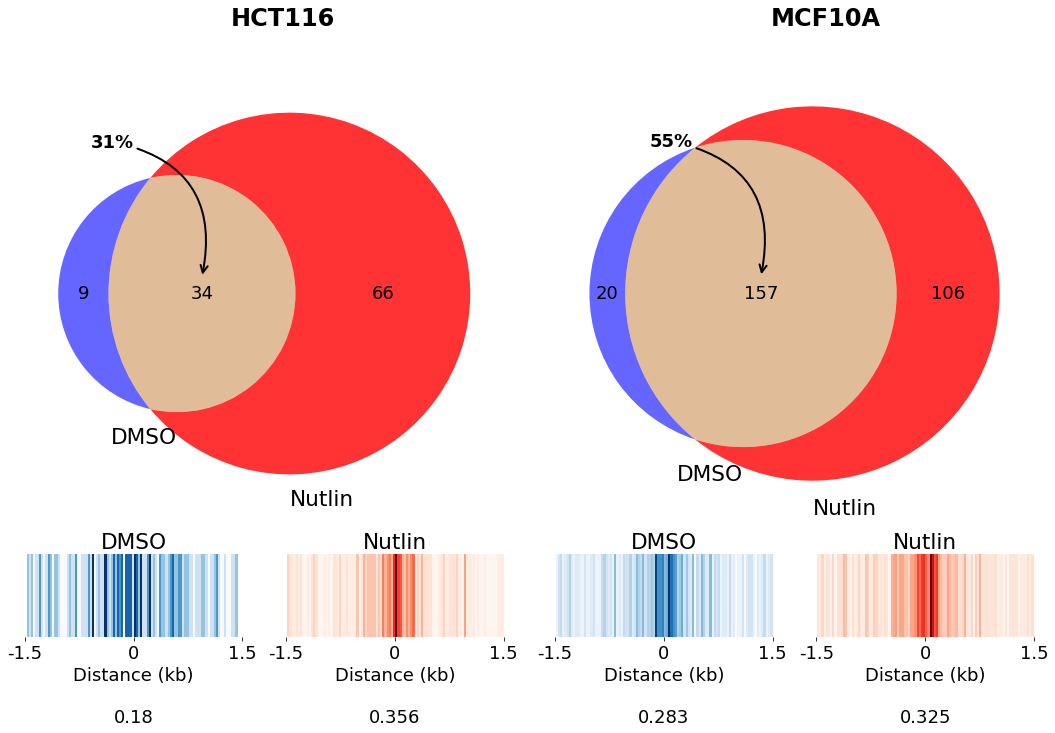

/Users/joru1876/TFEA_Jupyter/Figures/Supp_Nutlin_Method_Comparison_MD.pdf

In [12]:
def fasta_names(fastafile=None):
    names = list()
    with open(fastafile) as F:
        for line in F:
            if line[0] == '>':
                names.append(line[1:].strip('\n'))
    
    return names

def heatmap(distances, ax=None, xlim=None, bins=None, title=None, 
            largewindow=None, cmap='', smallwindow=150, horizontal=False):
    distances = [x for x in distances if x != '.']
    counts, edges = np.histogram(distances, bins=bins)
    edges = (edges[1:]+edges[:-1])/2.0
    norm    = matplotlib.colors.Normalize(vmin=min(counts), 
                                            vmax=max(counts))
    if cmap == 'blues':
        cmap    = cm.Blues
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'oranges':
        cmap    = cm.Oranges
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'reds':
        cmap    = cm.Reds
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'greens':
        cmap    = cm.Greens
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    
    if horizontal:
        ax.barh(edges,(edges[-1]-edges[0])/len(edges), height=np.ones((len(edges),)), 
               color=colors, edgecolor=colors)
        
        ax.tick_params(axis='x', which='both', bottom=False, top=False, 
                        labelbottom=False) 
        ax.tick_params(axis='y', which='both', left=True, right=False, 
                        labelleft=True)
        md = len([x for x in distances if abs(x) <= 150 and x !='.'])/len([x for x in distances if x != '.'])
        ax.set_ylabel(f'Distance (kb)\n\n{str("%.3g" % md)}')
        ax.set_yticks([-largewindow, 0, largewindow])
        ax.set_yticklabels([str(-largewindow/1000), 0, str(largewindow/1000)])
    else:
        ax.bar(edges,np.ones((len(edges),)), color=colors, 
                width=(edges[-1]-edges[0])/len(edges), edgecolor=colors)
        ax.set_ylim([0,1])
        ax.set_xlim([-largewindow, largewindow])
#     ax.axvline(-smallwindow, linestyle='--', c='k', alpha=0.5)
#     ax.axvline(smallwindow, linestyle='--', c='k', alpha=0.5)
        ax.tick_params(axis='y', which='both', left=False, right=False, 
                        labelleft=False) 
        ax.tick_params(axis='x', which='both', bottom=True, top=False, 
                        labelbottom=True)
        md = len([x for x in distances if abs(x) <= 150])/len(distances)
        ax.set_xlabel(f'Distance (kb)\n\n{str("%.3g" % md)}')
        ax.set_xticks([-largewindow, 0, largewindow])
        ax.set_xticklabels([str(-largewindow/1000), 0, str(largewindow/1000)])
    if title is not None:
        ax.set_title(title)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    return

def parse_fimo_venn(fimo_res1, fimo_res2):
    overlap1 = []
    overlap2 = []
    intersect = []
    heatmap1 = {}
    heatmap2 = {}
    venn = [0 for i in range(3)]

    for line1 in fimo_res1[2:]:
        line1_list = line1.split('\t')
        region1 = line1_list[2]
        start1,stop1 = region1.split(':')[1].split('-')
        start1,stop1 = int(start1),int(stop1)
        score1 = float(line1_list[6])
        motif1_distance = np.mean([int(line1_list[3]), int(line1_list[4])]) - largewindow
        if region1 not in heatmap1:
            heatmap1[region1] = [score1, motif1_distance]
        elif score1 > heatmap1[region1][0]:
            heatmap1[region1] = [score1, motif1_distance]
            
    for line2 in fimo_res2[2:]:
        line2_list = line2.split('\t')
        region2 = line2_list[2]
        start2,stop2 = region2.split(':')[1].split('-')
        start2,stop2 = int(start2),int(stop2)
        score2 = float(line2_list[6])
        motif = int(start2) + np.mean([int(line2_list[3]), int(line2_list[4])])
        motif2_distance = np.mean([int(line2_list[3]), int(line2_list[4])]) - largewindow
        if region2 not in heatmap2:
            heatmap2[region2] = [score2, motif2_distance]
        elif score2 > heatmap2[region2][0]:
            heatmap2[region2] = [score2, motif2_distance]
            
            
    for region1 in heatmap1:
        chrom1 = region1.split(':')[0]
        start1,stop1 = region1.split(':')[1].split('-')
        start1,stop1 = int(start1),int(stop1)
        motif1_distance = heatmap1[region1]
        for region2 in heatmap2:
            chrom2 = region2.split(':')[0]
            start2,stop2 = region2.split(':')[1].split('-')
            start2,stop2 = int(start2),int(stop2)
            motif2_distance = heatmap2[region2]
            if chrom1 == chrom2 and (start1 <= start2 <= stop1 or start1 <= stop2 <= stop1):
                if abs(motif1_distance[1]) < 150 or abs(motif2_distance[1]) < 150:
                    overlap1.append(region1)
                    overlap2.append(region2)
                    #muMerge here?
                    i_start = min(start1, start2)
                    i_stop = max(stop1, stop2)
                    i_mid = np.mean([i_start, i_stop])
                    i_motif_distance = motif - i_mid
    #                 intersect.append(i_motif_distance)

#     heatmap1 = [d for i,d in enumerate(heatmap1) if i not in overlap1]
#     heatmap2 = [d for i,d in enumerate(heatmap2) if i not in overlap2]
    overlap1 = list(set(overlap1))
    overlap2 = list(set(overlap2))
    venn[2] = max(len(overlap1), len(overlap2))
    venn[0] = len([region for region in heatmap1 if region not in overlap1 and abs(heatmap1[region][1]) < 150])
    venn[1] = len([region for region in heatmap2 if region not in overlap2 and abs(heatmap2[region][1]) < 150])
    
    return [v[1] for v in heatmap1.values()], [v[1] for v in heatmap2.values()], venn

def parse_fimo(fimo_stdout=None, largewindow=None, retain='score', 
                        names=None):
    d = dict()
    lines = fimo_stdout
    header = lines[1].split('\t')
    max_score = 0
    if len(header) > 1:
        start_index = header.index('start')
        stop_index = header.index('stop')
        name_index = header.index('sequence_name')
        score_index = header.index('score')
    for item in lines[2:-1]: #To remove header and empty last line in output
        line_list = item.split('\t')
        id = line_list[name_index]
        start = line_list[start_index]
        stop = line_list[stop_index]
        distance = ((int(start)+int(stop))/2)-int(largewindow)
        score = float(line_list[score_index])
        if id not in d:
            d[id] = [score, distance]
        else:
            prev_score = d[id][0]
            if prev_score < score:
                d[id] = [score, distance]

    distances = [] 
    for name in names:
        if name in d:
            distances.append(d[name][1])
        else:
            distances.append('.')

    return distances

def deseq_parse(deseq_file, basemean_cut=0):
    #Parse the DE-Seq output file
    up = list()
    down = list()
    with open(deseq_file) as F:
        header = F.readline().strip('\n').split('\t')
        fc_index = [i for i in range(len(header)) 
                    if header[i]=='"fc"' or header[i]=='"foldChange"'][0]
        basemean_index = [i for i in range(len(header)) if header[i]=='"baseMean"'][0]
        for line in F:
            line = line.strip('\n').split('\t')
            if line[fc_index+1] != 'NA':
                try:
                    pval = format(float(line[-2]),'.12f')
                except ValueError:
                    pval = format(1.0,'.12f')
                region = line[0].split(':')
                chrom = region[0]
                coordinates = region[1].split('-')
                start = coordinates[0]
                stop = coordinates[1]
                chrom = chrom.strip('"')
                stop = stop.strip('"')
                center = int((int(start)+int(stop))/2)
                start = center - int(largewindow)
                start = start if start > 0 else 0
                stop = center + int(largewindow)
                fc = float(line[fc_index+1])
                basemean = float(line[basemean_index+1])
                if basemean > basemean_cut:
                    if fc < 1:
                        down.append([chrom, str(start), str(stop), str(fc), str(pval)])
                    else:
                        up.append([chrom, str(start), str(stop), str(fc), str(pval)])
    #Save ranked regions in a bed file (pvalue included)
    pvals = list()
    fcs = list()
    for region in sorted(up, key=lambda x: x[4]):
        pvals.append(float(region[-1]))
        fcs.append(float(region[3]))
    for region in sorted(down, key=lambda x: x[4], reverse=True):
        pvals.append(float(region[-1]))
        fcs.append(float(region[3]))
        
    logpval = list()
    for x,y in zip(pvals,fcs):
        try:
            if y < 1:
                logpval.append(math.log(x,10))
            else:
                logpval.append(-math.log(x,10))
        except:
            logpval.append(0.0)

    return logpval, pvals

def enrichment_calculate_plot(distances, **kwargs):
    nan = float('Nan')
    distances_abs = [abs(x)  if x != '.' else x for x in distances]

    hits = len([x for x in distances_abs if x != '.'])

    #Get -exp() of distance and get cumulative scores
    #Filter distances into quartiles to get middle distribution
    q1 = int(round(len(distances)*.25))
    q3 = int(round(len(distances)*.75))
    middledistancehist =  [x for x in distances_abs[int(q1):int(q3)] if x != '.']
    average_distance = np.mean(middledistancehist)
    score = [math.exp(-float(x)/average_distance) if x != '.' else 0.0 for x in distances_abs]
    total = np.sum(score)

    binwidth = 1.0/float(len(distances_abs))
    normalized_score = np.multiply(np.divide(score, total), binwidth)
    cumscore = np.cumsum(normalized_score)
    trend = np.append(np.arange(0,1,1.0/float(len(cumscore) - 1)), 1.0)
    trend = np.multiply(trend, binwidth)

    #The AUC is the relative to the "random" line
    auc = np.trapz(cumscore) - np.trapz(trend)
    plotting_score = np.divide(score, total)
    # [(float(x)/total) for x in score]
    plotting_cumscore = np.cumsum(plotting_score)
    lineplot(yvals=plotting_cumscore, auc=auc, **kwargs)
    
def lineplot(title=None, ax=None, xvals=None, yvals=None, xlimits=None, auc=0):
    #This is the enrichment score plot (i.e. line plot)
    ax.plot(xvals,yvals,color='green')
    ax.plot([0, 1],[0, 1], '--', alpha=0.75)
    ax.set_title(title)
    ax.set_ylabel('Enrichment\nScore (ES)')
#     ax.tick_params(axis='y', which='both', left=True, right=False, 
#                     labelleft=True)
#     ax.tick_params(axis='x', which='both', bottom=False, top=False, 
#                     labelbottom=False)
    ax.set_ylim([0,1])
    ax.set_xlim(xlimits)
    ax.set_xticks([0,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f'Relative Rank (n={len(xvals)})\n\n{str("%.3g" % auc)}')
    return

def scatterplot(ax=None, xvals=None, yvals=None, xlimits=None, largewindow=None, 
                xlabel=False, axvline=0.2):
    #This is the barplot right below the enrichment score line plot
    ax.scatter(xvals, yvals, edgecolor="", color="black", 
                    s=10, alpha=0.25)
    if axvline:
        ax.set_xticks([0,axvline, 1])
        ax.set_xticklabels(['0','','1'])
        ax.axvline(axvline, linestyle='--', c='k', linewidth=2, alpha=0.5)
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0','1'])
    ax.set_yticks([-int(largewindow),0,int(largewindow)])
    ax.set_yticklabels([str(largewindow/-1000.0), '0', str(largewindow/1000.0)])
    ax.set_xlim(xlimits)
    ax.set_ylim([-int(largewindow),int(largewindow)])
    ax.set_ylabel('Distance (kb)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def fillplot(ax=None, xvals=None, yvals=None, xlimits=[0,1], ylimits=None, axvline=0.2):
    #This is the rank metric fill plot
    posvals = [(x,y) for x,y in zip(xvals,yvals) if y > 0]
    negvals = [(x,y) for x,y in zip(xvals,yvals) if y < 0]
    ax.fill_between([x for x,_ in posvals], 0, [y for _,y in posvals],facecolor='red',edgecolor="")
    ax.fill_between([x for x,_ in negvals], 0, [y for _,y in negvals],facecolor='blue',edgecolor="")
    if ylimits is None:
        ylim = math.fabs(max([x for x in yvals if -500 < x < 500],key=abs))
        ax.set_yticks([int(-ylim), 0, int(ylim)])
        ax.set_ylim([int(-ylim), 0, int(ylim)])
    else:
        ax.set_yticks([ylimits[0], 0, ylimits[1]])
        ax.set_ylim(ylimits)
    if axvline:
        ax.set_xticks([0,0.2, 1])
        ax.set_xticklabels(['0','0.2','1'])
        ax.axvline(0.2, linestyle='--', c='k', linewidth=2, alpha=0.5)
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0','1'])
    ax.set_xlim(xlimits)
    ax.set_ylabel('Rank Metric')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def mdd_fillplot(ax=None, xvals=None, yvals=None, xlimits=[0,1], ylimits=None, axvline=0.2):
    #This is the rank metric fill plot
#     ax.fill_between(xvals, 0, yvals ,facecolor='red',edgecolor="")
    ax.plot(xvals,yvals,c="r")
    ax.axhline(0, c='r')
    if ylimits is None:
        ylim = math.fabs(max([x for x in yvals if -500 < x < 500], key=abs))
        ax.set_yticks([int(-ylim), 0, int(ylim)])
        ax.set_ylim([int(-ylim), 0, int(ylim)])
    else:
        ax.set_yticks([ylimits[0], 0, ylimits[1]])
        ax.set_ylim(ylimits)
    if axvline:
        ax.set_xticks([0, axvline, 1])
        ax.set_xticklabels(['0','','1'])
        ax.text(axvline, 2, ' DE-Seq p-val 0.2', horizontalalignment='left')
        ax.axvline(axvline, linestyle='--', c='k', linewidth=2, alpha=0.5)
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0', '1'])
    ax.set_xlim(xlimits)
    ax.set_ylabel('$-log_{10}$(DE-Seq p-value)', fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

#=============================================================

largewindow = 1500

Allen_deseq = '/scratch/Users/joru1876/TFEA_files/Allen2014/v5_output/20190620_DMSO_Nutlin_mumerge/temp_files/DESeq.res.txt'
Allen_fasta = '/scratch/Users/joru1876/TFEA_files/Allen2014/v5_output/20190620_DMSO_Nutlin_mumerge/temp_files/ranked_file.fa'
Levandowski_deseq = '/scratch/Users/joru1876/Taatjes/CECIE_PROSEQ/TFEA/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/DESeq.res.txt'
Levandowski_fasta = '/scratch/Users/joru1876/Taatjes/CECIE_PROSEQ/TFEA/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/ranked_file.fa'

Allen_heatmap1, Allen_heatmap2, Allen_venn = parse_fimo_venn(Allen_md1_fimo, Allen_md2_fimo)
Levandowski_heatmap1, Levandowski_heatmap2, Levandowski_venn = parse_fimo_venn(Levandowski_md1_fimo, Levandowski_md2_fimo)
Levandowski_venn_sum = np.sum(Levandowski_venn)
Allen_venn_sum = np.sum(Allen_venn)
Allen_fasta_regions = fasta_names(fastafile=Allen_fasta)
Levandowski_fasta_regions = fasta_names(fastafile=Levandowski_fasta)
Allen_distances = parse_fimo(fimo_stdout=Allen_combined_fimo, largewindow=largewindow, 
                                names=Allen_fasta_regions)
Levandowski_distances = parse_fimo(fimo_stdout=Levandowski_combined_fimo, largewindow=largewindow, 
                                names=Levandowski_fasta_regions)

F = plt.figure(figsize=(15,10))
outer = gridspec.GridSpec(2, 2, height_ratios=[12,2])
i = 0


#HCT116 Venn
inner1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
ax1 = F.add_subplot(inner1[0])
# ax1.set_title("HCT116", fontweight='bold')
v = venn2(subsets=Allen_venn, 
          set_labels=('DMSO', 'Nutlin'), ax=ax1)
v.get_patch_by_id('10').set_color('b')
v.get_patch_by_id('01').set_color('r')
v.get_patch_by_id('10').set_alpha(0.6)
v.get_patch_by_id('01').set_alpha(0.8)
v.get_patch_by_id('01').set_linewidth(0)
v.get_patch_by_id('10').set_linewidth(0)
plt.annotate(str('%.2g' % (100*Allen_venn[2]/sum(Allen_venn))) + '%', fontweight='bold',
             xy=v.get_label_by_id('11').get_position() - np.array([0, -0.05]), xytext=(-90,130),
             ha='center', textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5',color='black', linewidth=2))

ax1.margins(Allen_venn_sum/Levandowski_venn_sum)
i+=1


#MCF10A Venn
inner1 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
ax1 = F.add_subplot(inner1[0])
# ax1.set_title("MCF10A", fontweight='bold')
v = venn2(subsets=Levandowski_venn, 
          set_labels=('DMSO', 'Nutlin'), ax=ax1)
v.get_patch_by_id('10').set_color('b')
v.get_patch_by_id('01').set_color('r')
v.get_patch_by_id('10').set_alpha(0.6)
v.get_patch_by_id('01').set_alpha(0.8)
v.get_patch_by_id('01').set_linewidth(0)
v.get_patch_by_id('10').set_linewidth(0)
plt.annotate(str('%.2g' % (100*Levandowski_venn[2]/sum(Levandowski_venn))) + '%', fontweight='bold',
             xy=v.get_label_by_id('11').get_position() - np.array([0, -0.05]), xytext=(-90,130),
             ha='center', textcoords='offset points', 
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=-0.5',color='black', linewidth=2))
i+=1


#MD HCT116 Heatmaps
F.text(0.225, 1, 'HCT116',fontweight='bold', fontsize=24)
inner2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i])
ax3 = F.add_subplot(inner2[0])
heatmap(Allen_heatmap1, ax=ax3, largewindow=largewindow, bins=100, cmap='blues', title="DMSO")
ax4 = F.add_subplot(inner2[1])
heatmap(Allen_heatmap2, ax=ax4, largewindow=largewindow, bins=100, cmap='reds', title="Nutlin")
i += 1


#MD MCF10A Heatmaps
F.text(0.725, 1, 'MCF10A',fontweight='bold', fontsize=24)
inner2 = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i])
ax3 = F.add_subplot(inner2[0])
heatmap(Levandowski_heatmap1, ax=ax3, largewindow=largewindow, bins=100, cmap='blues', title="DMSO")
ax4 = F.add_subplot(inner2[1])
heatmap(Levandowski_heatmap2, ax=ax4, largewindow=largewindow, bins=100, cmap='reds', title="Nutlin")
i += 1




outer.tight_layout(F)
figname = os.path.join(figuredir, 'Supp_Nutlin_Method_Comparison_MD.pdf')
F.savefig(figname, bbox_inches='tight', format='pdf', transparent=True)
plt.show()
FileLink(str(Path(figname).relative_to(Path.cwd())))

## Supplemental Figure MDD-Score

/opt/jupyterhub/venv/lib/python3.6/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


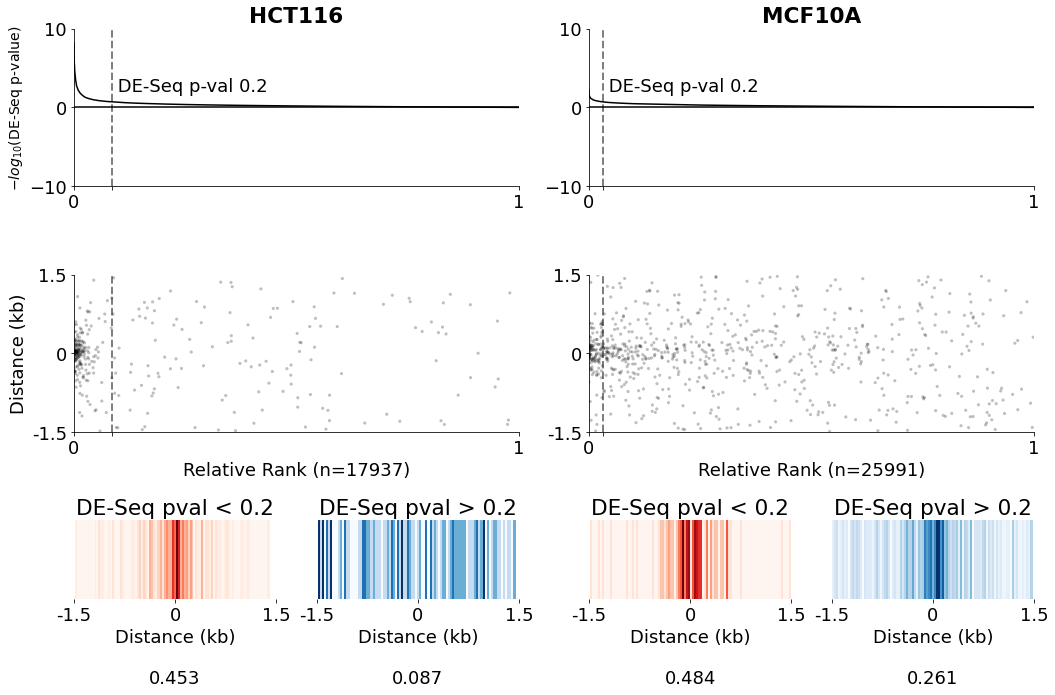

/Users/joru1876/TFEA_Jupyter/Figures/Supp_Nutlin_Method_Comparison_MDD.pdf

In [13]:
def fasta_names(fastafile=None):
    names = list()
    with open(fastafile) as F:
        for line in F:
            if line[0] == '>':
                names.append(line[1:].strip('\n'))
    
    return names

def heatmap(distances, ax=None, xlim=None, bins=None, title=None, 
            largewindow=None, cmap='', smallwindow=150, horizontal=False):
    distances = [x for x in distances if x != '.']
    counts, edges = np.histogram(distances, bins=bins)
    edges = (edges[1:]+edges[:-1])/2.0
    norm    = matplotlib.colors.Normalize(vmin=min(counts), 
                                            vmax=max(counts))
    if cmap == 'blues':
        cmap    = cm.Blues
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'oranges':
        cmap    = cm.Oranges
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'reds':
        cmap    = cm.Reds
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'greens':
        cmap    = cm.Greens
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    
    if horizontal:
        ax.barh(edges,(edges[-1]-edges[0])/len(edges), height=np.ones((len(edges),)), 
               color=colors, edgecolor=colors)
        
        ax.tick_params(axis='x', which='both', bottom=False, top=False, 
                        labelbottom=False) 
        ax.tick_params(axis='y', which='both', left=True, right=False, 
                        labelleft=True)
        md = len([x for x in distances if x < 150 and x !='.'])/len([x for x in distances if x != '.'])
        ax.set_ylabel(f'Distance (kb)\n\n{str("%.3g" % md)}')
        ax.set_yticks([-largewindow, 0, largewindow])
        ax.set_yticklabels([str(-largewindow/1000), 0, str(largewindow/1000)])
    else:
        ax.bar(edges,np.ones((len(edges),)), color=colors, 
                width=(edges[-1]-edges[0])/len(edges), edgecolor=colors)
        ax.set_ylim([0,1])
        ax.set_xlim([-largewindow, largewindow])
#     ax.axvline(-smallwindow, linestyle='--', c='k', alpha=0.5)
#     ax.axvline(smallwindow, linestyle='--', c='k', alpha=0.5)
        ax.tick_params(axis='y', which='both', left=False, right=False, 
                        labelleft=False) 
        ax.tick_params(axis='x', which='both', bottom=True, top=False, 
                        labelbottom=True)
        md = len([x for x in distances if abs(x) < 150])/len(distances)
        ax.set_xlabel(f'Distance (kb)\n\n{str("%.3g" % md)}')
        ax.set_xticks([-largewindow, 0, largewindow])
        ax.set_xticklabels([str(-largewindow/1000), 0, str(largewindow/1000)])
    if title is not None:
        ax.set_title(title)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    return

def parse_fimo_venn(fimo_res1, fimo_res2):
    overlap1 = []
    overlap2 = []
    intersect = []
    heatmap1 = {}
    heatmap2 = {}
    venn = [0 for i in range(3)]

    for line1 in fimo_res1[2:]:
        line1_list = line1.split('\t')
        region1 = line1_list[2]
        start1,stop1 = region1.split(':')[1].split('-')
        start1,stop1 = int(start1),int(stop1)
        score1 = float(line1_list[6])
        motif1_distance = np.mean([int(line1_list[3]), int(line1_list[4])]) - largewindow
        if region1 not in heatmap1:
            heatmap1[region1] = [score1, motif1_distance]
        elif score1 > heatmap1[region1][0]:
            heatmap1[region1] = [score1, motif1_distance]
            
    for line2 in fimo_res2[2:]:
        line2_list = line2.split('\t')
        region2 = line2_list[2]
        start2,stop2 = region2.split(':')[1].split('-')
        start2,stop2 = int(start2),int(stop2)
        score2 = float(line2_list[6])
        motif = int(start2) + np.mean([int(line2_list[3]), int(line2_list[4])])
        motif2_distance = np.mean([int(line2_list[3]), int(line2_list[4])]) - largewindow
        if region2 not in heatmap2:
            heatmap2[region2] = [score2, motif2_distance]
        elif score2 > heatmap2[region2][0]:
            heatmap2[region2] = [score2, motif2_distance]
            
            
    for region1 in heatmap1:
        chrom1 = region1.split(':')[0]
        start1,stop1 = region1.split(':')[1].split('-')
        start1,stop1 = int(start1),int(stop1)
        motif1_distance = heatmap1[region1]
        for region2 in heatmap2:
            chrom2 = region2.split(':')[0]
            start2,stop2 = region2.split(':')[1].split('-')
            start2,stop2 = int(start2),int(stop2)
            motif2_distance = heatmap2[region2]
            if chrom1 == chrom2 and (start1 <= start2 <= stop1 or start1 <= stop2 <= stop1):
                if abs(motif1_distance[1]) < 150 or abs(motif2_distance[1]) < 150:
                    overlap1.append(region1)
                    overlap2.append(region2)
                    #muMerge here?
                    i_start = min(start1, start2)
                    i_stop = max(stop1, stop2)
                    i_mid = np.mean([i_start, i_stop])
                    i_motif_distance = motif - i_mid
    #                 intersect.append(i_motif_distance)

#     heatmap1 = [d for i,d in enumerate(heatmap1) if i not in overlap1]
#     heatmap2 = [d for i,d in enumerate(heatmap2) if i not in overlap2]
    overlap1 = list(set(overlap1))
    overlap2 = list(set(overlap2))
    venn[2] = max(len(overlap1), len(overlap2))
    venn[0] = len([region for region in heatmap1 if region not in overlap1 and abs(heatmap1[region][1]) < 150])
    venn[1] = len([region for region in heatmap2 if region not in overlap2 and abs(heatmap2[region][1]) < 150])
    
    return [v[1] for v in heatmap1.values()], [v[1] for v in heatmap2.values()], venn

def parse_fimo(fimo_stdout=None, largewindow=None, retain='score', 
                        names=None):
    d = dict()
    lines = fimo_stdout
    header = lines[1].split('\t')
    max_score = 0
    if len(header) > 1:
        start_index = header.index('start')
        stop_index = header.index('stop')
        name_index = header.index('sequence_name')
        score_index = header.index('score')
    for item in lines[2:-1]: #To remove header and empty last line in output
        line_list = item.split('\t')
        id = line_list[name_index]
        start = line_list[start_index]
        stop = line_list[stop_index]
        distance = ((int(start)+int(stop))/2)-int(largewindow)
        score = float(line_list[score_index])
        if id not in d:
            d[id] = [score, distance]
        else:
            prev_score = d[id][0]
            if prev_score < score:
                d[id] = [score, distance]

    distances = [] 
    for name in names:
        if name in d:
            distances.append(d[name][1])
        else:
            distances.append('.')

    return distances

def deseq_parse(deseq_file, basemean_cut=0):
    #Parse the DE-Seq output file
    up = list()
    down = list()
    with open(deseq_file) as F:
        header = F.readline().strip('\n').split('\t')
        fc_index = [i for i in range(len(header)) 
                    if header[i]=='"fc"' or header[i]=='"foldChange"'][0]
        basemean_index = [i for i in range(len(header)) if header[i]=='"baseMean"'][0]
        for line in F:
            line = line.strip('\n').split('\t')
            if line[fc_index+1] != 'NA':
                try:
                    pval = format(float(line[-2]),'.12f')
                except ValueError:
                    pval = format(1.0,'.12f')
                region = line[0].split(':')
                chrom = region[0]
                coordinates = region[1].split('-')
                start = coordinates[0]
                stop = coordinates[1]
                chrom = chrom.strip('"')
                stop = stop.strip('"')
                center = int((int(start)+int(stop))/2)
                start = center - int(largewindow)
                start = start if start > 0 else 0
                stop = center + int(largewindow)
                fc = float(line[fc_index+1])
                basemean = float(line[basemean_index+1])
                if basemean > basemean_cut:
                    if fc < 1:
                        down.append([chrom, str(start), str(stop), str(fc), str(pval)])
                    else:
                        up.append([chrom, str(start), str(stop), str(fc), str(pval)])
    #Save ranked regions in a bed file (pvalue included)
    pvals = list()
    fcs = list()
    for region in sorted(up, key=lambda x: x[4]):
        pvals.append(float(region[-1]))
        fcs.append(float(region[3]))
    for region in sorted(down, key=lambda x: x[4], reverse=True):
        pvals.append(float(region[-1]))
        fcs.append(float(region[3]))
        
    logpval = list()
    for x,y in zip(pvals,fcs):
        try:
            if y < 1:
                logpval.append(math.log(x,10))
            else:
                logpval.append(-math.log(x,10))
        except:
            logpval.append(0.0)

    return logpval, pvals

def enrichment_calculate_plot(distances, **kwargs):
    nan = float('Nan')
    distances_abs = [abs(x)  if x != '.' else x for x in distances]

    hits = len([x for x in distances_abs if x != '.'])

    #Get -exp() of distance and get cumulative scores
    #Filter distances into quartiles to get middle distribution
    q1 = int(round(len(distances)*.25))
    q3 = int(round(len(distances)*.75))
    middledistancehist =  [x for x in distances_abs[int(q1):int(q3)] if x != '.']
    average_distance = np.mean(middledistancehist)
    score = [math.exp(-float(x)/average_distance) if x != '.' else 0.0 for x in distances_abs]
    total = np.sum(score)

    binwidth = 1.0/float(len(distances_abs))
    normalized_score = np.multiply(np.divide(score, total), binwidth)
    cumscore = np.cumsum(normalized_score)
    trend = np.append(np.arange(0,1,1.0/float(len(cumscore) - 1)), 1.0)
    trend = np.multiply(trend, binwidth)

    #The AUC is the relative to the "random" line
    auc = np.trapz(cumscore) - np.trapz(trend)
    plotting_score = np.divide(score, total)
    # [(float(x)/total) for x in score]
    plotting_cumscore = np.cumsum(plotting_score)
    lineplot(yvals=plotting_cumscore, auc=auc, **kwargs)
    
def lineplot(title=None, ax=None, xvals=None, yvals=None, xlimits=None, auc=0):
    #This is the enrichment score plot (i.e. line plot)
    ax.plot(xvals,yvals,color='green')
    ax.plot([0, 1],[0, 1], '--', alpha=0.75)
    ax.set_title(title)
    ax.set_ylabel('Enrichment\nScore (ES)')
#     ax.tick_params(axis='y', which='both', left=True, right=False, 
#                     labelleft=True)
#     ax.tick_params(axis='x', which='both', bottom=False, top=False, 
#                     labelbottom=False)
    ax.set_ylim([0,1])
    ax.set_xlim(xlimits)
    ax.set_xticks([0,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f'Relative Rank (n={len(xvals)})\n\n{str("%.3g" % auc)}')
    return

def scatterplot(ax=None, xvals=None, yvals=None, xlimits=None, largewindow=None, 
                xlabel=False, axvline=0.2):
    #This is the barplot right below the enrichment score line plot
    ax.scatter(xvals, yvals, edgecolor="", color="black", 
                    s=10, alpha=0.25)
    if axvline:
        ax.set_xticks([0,axvline, 1])
        ax.set_xticklabels(['0','','1'])
        ax.axvline(axvline, linestyle='--', c='k', linewidth=2, alpha=0.5)
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0','1'])
    ax.set_yticks([-int(largewindow),0,int(largewindow)])
    ax.set_yticklabels([str(largewindow/-1000.0), '0', str(largewindow/1000.0)])
    ax.set_xlim(xlimits)
    ax.set_ylim([-int(largewindow),int(largewindow)])
    ax.set_ylabel('Distance (kb)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def fillplot(ax=None, xvals=None, yvals=None, xlimits=[0,1], ylimits=None, axvline=0.2):
    #This is the rank metric fill plot
    posvals = [(x,y) for x,y in zip(xvals,yvals) if y > 0]
    negvals = [(x,y) for x,y in zip(xvals,yvals) if y < 0]
    ax.fill_between([x for x,_ in posvals], 0, [y for _,y in posvals],facecolor='red',edgecolor="")
    ax.fill_between([x for x,_ in negvals], 0, [y for _,y in negvals],facecolor='blue',edgecolor="")
    if ylimits is None:
        ylim = math.fabs(max([x for x in yvals if -500 < x < 500],key=abs))
        ax.set_yticks([int(-ylim), 0, int(ylim)])
        ax.set_ylim([int(-ylim), 0, int(ylim)])
    else:
        ax.set_yticks([ylimits[0], 0, ylimits[1]])
        ax.set_ylim(ylimits)
    if axvline:
        ax.set_xticks([0,0.2, 1])
        ax.set_xticklabels(['0','0.2','1'])
        ax.axvline(0.2, linestyle='--', c='k', linewidth=2, alpha=0.5)
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0','1'])
    ax.set_xlim(xlimits)
    ax.set_ylabel('Rank Metric')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def mdd_fillplot(ax=None, xvals=None, yvals=None, xlimits=[0,1], ylimits=None, axvline=0.2):
    #This is the rank metric fill plot
#     ax.fill_between(xvals, 0, yvals ,facecolor='black', edgecolor="", interpolate=True)
    ax.plot(xvals,yvals,c="k")
    ax.axhline(0, c='k')
    if ylimits is None:
        ylim = math.fabs(max([x for x in yvals if -500 < x < 500], key=abs))
        ax.set_yticks([int(-ylim), 0, int(ylim)])
        ax.set_ylim([int(-ylim), 0, int(ylim)])
    else:
        ax.set_yticks([ylimits[0], 0, ylimits[1]])
        ax.set_ylim(ylimits)
    if axvline:
        ax.set_xticks([0, axvline, 1])
        ax.set_xticklabels(['0','','1'])
        ax.text(axvline, 2, ' DE-Seq p-val 0.2', horizontalalignment='left')
        ax.axvline(axvline, linestyle='--', c='k', linewidth=2, alpha=0.5)
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0', '1'])
    ax.set_xlim(xlimits)
    ax.set_ylabel('$-log_{10}$(DE-Seq p-value)', fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

#=============================================================

largewindow = 1500

Allen_deseq = '/Users/joru1876/TFEA_files/Allen2014/v5_output/20190620_DMSO_Nutlin_mumerge/temp_files/DESeq.res.txt'
Allen_fasta = '/Users/joru1876/TFEA_files/Allen2014/v5_output/20190620_DMSO_Nutlin_mumerge/temp_files/ranked_file.fa'
Levandowski_deseq = '/Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/DESeq.res.txt'
Levandowski_fasta = '/Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/ranked_file.fa'

Allen_heatmap1, Allen_heatmap2, Allen_venn = parse_fimo_venn(Allen_md1_fimo, Allen_md2_fimo)
Levandowski_heatmap1, Levandowski_heatmap2, Levandowski_venn = parse_fimo_venn(Levandowski_md1_fimo, Levandowski_md2_fimo)
Levandowski_venn_sum = np.sum(Levandowski_venn)
Allen_venn_sum = np.sum(Allen_venn)
Allen_fasta_regions = fasta_names(fastafile=Allen_fasta)
Levandowski_fasta_regions = fasta_names(fastafile=Levandowski_fasta)
Allen_distances = parse_fimo(fimo_stdout=Allen_combined_fimo, largewindow=largewindow, 
                                names=Allen_fasta_regions)
Levandowski_distances = parse_fimo(fimo_stdout=Levandowski_combined_fimo, largewindow=largewindow, 
                                names=Levandowski_fasta_regions)

F = plt.figure(figsize=(15,10))
outer = gridspec.GridSpec(3, 2, height_ratios=[4,4,2])
i = 0


#MDD HCT116 rank fillplot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
_, Allen_pvals = deseq_parse(Allen_deseq)
Allen_logpvals = [-math.log(p, 10) for p in sorted(Allen_pvals)]
Allen_cutoff = len([x for x in Allen_logpvals if x > -math.log(0.2,10)])/len(Allen_logpvals)
xvals = np.linspace(start=0, stop=1, num=len(Allen_logpvals))
ax = F.add_subplot(inner[0])
mdd_fillplot(ax=ax, xvals=xvals, yvals=Allen_logpvals, xlimits=[0, 1], ylimits=[-10,10], axvline=Allen_cutoff)
ax.set_title('HCT116', fontweight='bold')
i+=1


#MDD MCF10A rank fillplot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
_, Levandowski_pvals = deseq_parse(Levandowski_deseq)
Levandowski_logpvals = [-math.log(p, 10) for p in sorted(Levandowski_pvals)]
Levandowski_cutoff = len([x for x in Levandowski_logpvals if x > -math.log(0.2,10)])/len(Levandowski_logpvals)
xvals = np.linspace(start=0, stop=1, num=len(Levandowski_logpvals))
ax = F.add_subplot(inner[0])
mdd_fillplot(ax=ax, xvals=xvals, yvals=Levandowski_logpvals, xlimits=[0, 1], ylimits=[-10,10], axvline=Levandowski_cutoff)
ax.set_ylabel('')
ax.set_title('MCF10A', fontweight='bold')
i+=1


#MDD HCT116 Scatterplot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
ax2 = F.add_subplot(inner[0])
mdd_sorted_Allen_distances_indices = np.argsort(Allen_pvals)
# mdd_sorted_Allen_distances = [Allen_distances[i] for i in mdd_sorted_Allen_distances_indices]
mdd_sorted_Allen_distances = Allen_distances
xvals = np.linspace(start=0, stop=1, num=len(mdd_sorted_Allen_distances))
scatter_data = [(i,x) for i,x in zip(xvals, mdd_sorted_Allen_distances) if x != '.']
scatter_x = [i for i,_ in scatter_data]
scatter_y = [x for _,x in scatter_data]
scatterplot(ax=ax2, xvals=scatter_x, yvals=scatter_y, xlimits=[0,1], largewindow=largewindow, 
                xlabel=False, axvline=Allen_cutoff)
ax2.set_xlabel(f'Relative Rank (n={len(xvals)})')
i+=1


#MDD MCF10A Scatterplot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
ax2 = F.add_subplot(inner[0])
mdd_sorted_Levandowski_distances_indices = np.argsort(Levandowski_pvals)
# mdd_sorted_Levandowski_distances = [Levandowski_distances[i] for i in mdd_sorted_Levandowski_distances_indices]
mdd_sorted_Levandowski_distances = Levandowski_distances
xvals = np.linspace(start=0, stop=1, num=len(mdd_sorted_Levandowski_distances))
scatter_data = [(i,x) for i,x in zip(xvals, mdd_sorted_Levandowski_distances) if x != '.']
scatter_x = [i for i,_ in scatter_data]
scatter_y = [x for _,x in scatter_data]
scatterplot(ax=ax2, xvals=scatter_x, yvals=scatter_y, xlimits=[0,1], largewindow=largewindow, 
                xlabel=False, axvline=Levandowski_cutoff)
ax2.set_ylabel('')
ax2.set_xlabel(f'Relative Rank (n={len(xvals)})')
i+=1


#MDD HCT116 heatmaps
inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i])

# index = int(len(Allen_distances) * 0.2)
Allen_index_cutoff = int(Allen_cutoff*len(mdd_sorted_Allen_distances))
Allen_mdd1_distances = mdd_sorted_Allen_distances[Allen_index_cutoff:]
Allen_mdd2_distances = mdd_sorted_Allen_distances[:Allen_index_cutoff]
ax1 = F.add_subplot(inner[0])
heatmap(Allen_mdd2_distances, ax=ax1, largewindow=largewindow, bins=100, cmap='reds', title="DE-Seq pval < 0.2")
ax3 = F.add_subplot(inner[1])
heatmap(Allen_mdd1_distances, ax=ax3, largewindow=largewindow, bins=100, cmap='blues', title="DE-Seq pval > 0.2")
i+=1


#MDD MCF10A heatmaps
inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i])

# index = int(len(Levandowski_distances) * 0.2)
# differential_indices = [i for i,pval in enumerate(Levandowski_pvals) if pval < 0.2]
# Levandowski_mdd1_distances = [Levandowski_distances[i] for i in differential_indices]
Levandowski_index_cutoff = int(Levandowski_cutoff*len(mdd_sorted_Levandowski_distances))
Levandowski_mdd1_distances = mdd_sorted_Levandowski_distances[Levandowski_index_cutoff:]
Levandowski_mdd2_distances = mdd_sorted_Levandowski_distances[:Levandowski_index_cutoff]
ax1 = F.add_subplot(inner[0])
heatmap(Levandowski_mdd2_distances, ax=ax1, largewindow=largewindow, bins=100, cmap='reds', title="DE-Seq pval < 0.2")
ax3 = F.add_subplot(inner[1])
heatmap(Levandowski_mdd1_distances, ax=ax3, largewindow=largewindow, bins=100, cmap='blues', title="DE-Seq pval > 0.2")
i+=1


outer.tight_layout(F)
figname = os.path.join(figuredir, 'Supp_Nutlin_Method_Comparison_MDD.pdf')
F.savefig(figname, bbox_inches='tight', format='pdf', transparent=True)
plt.show()
FileLink(str(Path(figname).relative_to(Path.cwd())))

## Supplemental Figure MDD-Score

/opt/jupyterhub/venv/lib/python3.6/site-packages/ipykernel_launcher.py:272: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


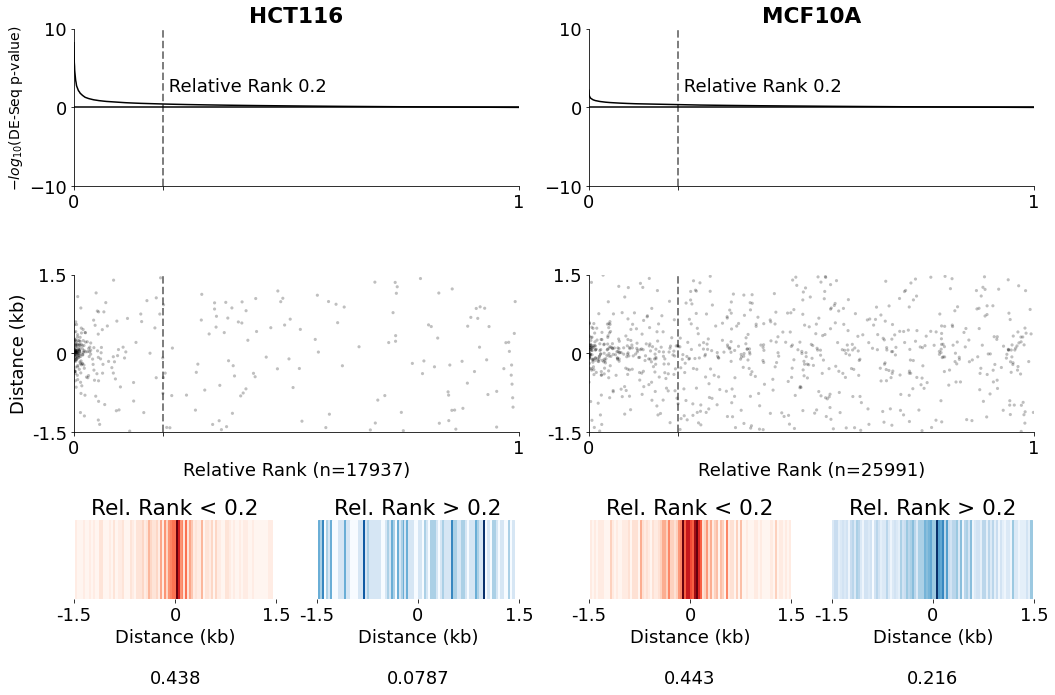

/Users/joru1876/TFEA_Jupyter/Figures/Supp_Nutlin_Method_Comparison_MDD_relrank0.2.pdf

In [14]:
def fasta_names(fastafile=None):
    names = list()
    with open(fastafile) as F:
        for line in F:
            if line[0] == '>':
                names.append(line[1:].strip('\n'))
    
    return names

def heatmap(distances, ax=None, xlim=None, bins=None, title=None, 
            largewindow=None, cmap='', smallwindow=150, horizontal=False):
    distances = [x for x in distances if x != '.']
    counts, edges = np.histogram(distances, bins=bins)
    edges = (edges[1:]+edges[:-1])/2.0
    norm    = matplotlib.colors.Normalize(vmin=min(counts), 
                                            vmax=max(counts))
    if cmap == 'blues':
        cmap    = cm.Blues
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'oranges':
        cmap    = cm.Oranges
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'reds':
        cmap    = cm.Reds
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'greens':
        cmap    = cm.Greens
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    
    if horizontal:
        ax.barh(edges,(edges[-1]-edges[0])/len(edges), height=np.ones((len(edges),)), 
               color=colors, edgecolor=colors)
        
        ax.tick_params(axis='x', which='both', bottom=False, top=False, 
                        labelbottom=False) 
        ax.tick_params(axis='y', which='both', left=True, right=False, 
                        labelleft=True)
        md = len([x for x in distances if abs(x) <= 150])/len(distances)
        ax.set_ylabel(f'Distance (kb)\n\n{str("%.3g" % md)}')
        ax.set_yticks([-largewindow, 0, largewindow])
        ax.set_yticklabels([str(-largewindow/1000), 0, str(largewindow/1000)])
    else:
        ax.bar(edges,np.ones((len(edges),)), color=colors, 
                width=(edges[-1]-edges[0])/len(edges), edgecolor=colors)
        ax.set_ylim([0,1])
        ax.set_xlim([-largewindow, largewindow])
#     ax.axvline(-smallwindow, linestyle='--', c='k', alpha=0.5)
#     ax.axvline(smallwindow, linestyle='--', c='k', alpha=0.5)
        ax.tick_params(axis='y', which='both', left=False, right=False, 
                        labelleft=False) 
        ax.tick_params(axis='x', which='both', bottom=True, top=False, 
                        labelbottom=True)
        md = len([x for x in distances if abs(x) <= 150])/len(distances)
        ax.set_xlabel(f'Distance (kb)\n\n{str("%.3g" % md)}')
        ax.set_xticks([-largewindow, 0, largewindow])
        ax.set_xticklabels([str(-largewindow/1000), 0, str(largewindow/1000)])
    if title is not None:
        ax.set_title(title)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    return

def parse_fimo_venn(fimo_res1, fimo_res2):
    overlap1 = []
    overlap2 = []
    intersect = []
    heatmap1 = {}
    heatmap2 = {}
    venn = [0 for i in range(3)]

    for line1 in fimo_res1[2:]:
        line1_list = line1.split('\t')
        region1 = line1_list[2]
        start1,stop1 = region1.split(':')[1].split('-')
        start1,stop1 = int(start1),int(stop1)
        score1 = float(line1_list[6])
        motif1_distance = np.mean([int(line1_list[3]), int(line1_list[4])]) - largewindow
        if region1 not in heatmap1:
            heatmap1[region1] = [score1, motif1_distance]
        elif score1 > heatmap1[region1][0]:
            heatmap1[region1] = [score1, motif1_distance]
            
    for line2 in fimo_res2[2:]:
        line2_list = line2.split('\t')
        region2 = line2_list[2]
        start2,stop2 = region2.split(':')[1].split('-')
        start2,stop2 = int(start2),int(stop2)
        score2 = float(line2_list[6])
        motif = int(start2) + np.mean([int(line2_list[3]), int(line2_list[4])])
        motif2_distance = np.mean([int(line2_list[3]), int(line2_list[4])]) - largewindow
        if region2 not in heatmap2:
            heatmap2[region2] = [score2, motif2_distance]
        elif score2 > heatmap2[region2][0]:
            heatmap2[region2] = [score2, motif2_distance]
            
            
    for region1 in heatmap1:
        chrom1 = region1.split(':')[0]
        start1,stop1 = region1.split(':')[1].split('-')
        start1,stop1 = int(start1),int(stop1)
        motif1_distance = heatmap1[region1]
        for region2 in heatmap2:
            chrom2 = region2.split(':')[0]
            start2,stop2 = region2.split(':')[1].split('-')
            start2,stop2 = int(start2),int(stop2)
            motif2_distance = heatmap2[region2]
            if chrom1 == chrom2 and (start1 <= start2 <= stop1 or start1 <= stop2 <= stop1):
                if abs(motif1_distance[1]) < 150 or abs(motif2_distance[1]) < 150:
                    overlap1.append(region1)
                    overlap2.append(region2)
                    #muMerge here?
                    i_start = min(start1, start2)
                    i_stop = max(stop1, stop2)
                    i_mid = np.mean([i_start, i_stop])
                    i_motif_distance = motif - i_mid
    #                 intersect.append(i_motif_distance)

#     heatmap1 = [d for i,d in enumerate(heatmap1) if i not in overlap1]
#     heatmap2 = [d for i,d in enumerate(heatmap2) if i not in overlap2]
    overlap1 = list(set(overlap1))
    overlap2 = list(set(overlap2))
    venn[2] = max(len(overlap1), len(overlap2))
    venn[0] = len([region for region in heatmap1 if region not in overlap1 and abs(heatmap1[region][1]) < 150])
    venn[1] = len([region for region in heatmap2 if region not in overlap2 and abs(heatmap2[region][1]) < 150])
    
    return [v[1] for v in heatmap1.values()], [v[1] for v in heatmap2.values()], venn

def parse_fimo(fimo_stdout=None, largewindow=None, retain='score', 
                        names=None):
    d = dict()
    lines = fimo_stdout
    header = lines[1].split('\t')
    max_score = 0
    if len(header) > 1:
        start_index = header.index('start')
        stop_index = header.index('stop')
        name_index = header.index('sequence_name')
        score_index = header.index('score')
    for item in lines[2:-1]: #To remove header and empty last line in output
        line_list = item.split('\t')
        id = line_list[name_index]
        start = line_list[start_index]
        stop = line_list[stop_index]
        distance = ((int(start)+int(stop))/2)-int(largewindow)
        score = float(line_list[score_index])
        if id not in d:
            d[id] = [score, distance]
        else:
            prev_score = d[id][0]
            if prev_score < score:
                d[id] = [score, distance]

    distances = [] 
    for name in names:
        if name in d:
            distances.append(d[name][1])
        else:
            distances.append('.')

    return distances

def deseq_parse(deseq_file, basemean_cut=0):
    #Parse the DE-Seq output file
    up = list()
    down = list()
    with open(deseq_file) as F:
        header = F.readline().strip('\n').split('\t')
        fc_index = [i for i in range(len(header)) 
                    if header[i]=='"fc"' or header[i]=='"foldChange"'][0]
        basemean_index = [i for i in range(len(header)) if header[i]=='"baseMean"'][0]
        for line in F:
            line = line.strip('\n').split('\t')
            if line[fc_index+1] != 'NA':
                try:
                    pval = format(float(line[-2]),'.12f')
                except ValueError:
                    pval = format(1.0,'.12f')
                region = line[0].split(':')
                chrom = region[0]
                coordinates = region[1].split('-')
                start = coordinates[0]
                stop = coordinates[1]
                chrom = chrom.strip('"')
                stop = stop.strip('"')
                center = int((int(start)+int(stop))/2)
                start = center - int(largewindow)
                start = start if start > 0 else 0
                stop = center + int(largewindow)
                fc = float(line[fc_index+1])
                basemean = float(line[basemean_index+1])
                if basemean > basemean_cut:
                    if fc < 1:
                        down.append([chrom, str(start), str(stop), str(fc), str(pval)])
                    else:
                        up.append([chrom, str(start), str(stop), str(fc), str(pval)])
    #Save ranked regions in a bed file (pvalue included)
    pvals = list()
    fcs = list()
    for region in sorted(up, key=lambda x: x[4]):
        pvals.append(float(region[-1]))
        fcs.append(float(region[3]))
    for region in sorted(down, key=lambda x: x[4], reverse=True):
        pvals.append(float(region[-1]))
        fcs.append(float(region[3]))
        
    logpval = list()
    for x,y in zip(pvals,fcs):
        try:
            if y < 1:
                logpval.append(math.log(x,10))
            else:
                logpval.append(-math.log(x,10))
        except:
            logpval.append(0.0)

    return logpval, pvals

def enrichment_calculate_plot(distances, **kwargs):
    nan = float('Nan')
    distances_abs = [abs(x)  if x != '.' else x for x in distances]

    hits = len([x for x in distances_abs if x != '.'])

    #Get -exp() of distance and get cumulative scores
    #Filter distances into quartiles to get middle distribution
    q1 = int(round(len(distances)*.25))
    q3 = int(round(len(distances)*.75))
    middledistancehist =  [x for x in distances_abs[int(q1):int(q3)] if x != '.']
    average_distance = np.mean(middledistancehist)
    score = [math.exp(-float(x)/average_distance) if x != '.' else 0.0 for x in distances_abs]
    total = np.sum(score)

    binwidth = 1.0/float(len(distances_abs))
    normalized_score = np.multiply(np.divide(score, total), binwidth)
    cumscore = np.cumsum(normalized_score)
    trend = np.append(np.arange(0,1,1.0/float(len(cumscore) - 1)), 1.0)
    trend = np.multiply(trend, binwidth)

    #The AUC is the relative to the "random" line
    auc = np.trapz(cumscore) - np.trapz(trend)
    plotting_score = np.divide(score, total)
    # [(float(x)/total) for x in score]
    plotting_cumscore = np.cumsum(plotting_score)
    lineplot(yvals=plotting_cumscore, auc=auc, **kwargs)
    
def lineplot(title=None, ax=None, xvals=None, yvals=None, xlimits=None, auc=0):
    #This is the enrichment score plot (i.e. line plot)
    ax.plot(xvals,yvals,color='green')
    ax.plot([0, 1],[0, 1], '--', alpha=0.75)
    ax.set_title(title)
    ax.set_ylabel('Enrichment\nScore (ES)')
#     ax.tick_params(axis='y', which='both', left=True, right=False, 
#                     labelleft=True)
#     ax.tick_params(axis='x', which='both', bottom=False, top=False, 
#                     labelbottom=False)
    ax.set_ylim([0,1])
    ax.set_xlim(xlimits)
    ax.set_xticks([0,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f'Relative Rank (n={len(xvals)})\n\n{str("%.3g" % auc)}')
    return

def scatterplot(ax=None, xvals=None, yvals=None, xlimits=None, largewindow=None, 
                xlabel=False, axvline=0.2):
    #This is the barplot right below the enrichment score line plot
    ax.scatter(xvals, yvals, edgecolor="", color="black", 
                    s=10, alpha=0.25)
    if axvline:
        ax.set_xticks([0,axvline, 1])
        ax.set_xticklabels(['0','','1'])
        ax.axvline(axvline, linestyle='--', c='k', linewidth=2, alpha=0.5)
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0','1'])
    ax.set_yticks([-int(largewindow),0,int(largewindow)])
    ax.set_yticklabels([str(largewindow/-1000.0), '0', str(largewindow/1000.0)])
    ax.set_xlim(xlimits)
    ax.set_ylim([-int(largewindow),int(largewindow)])
    ax.set_ylabel('Distance (kb)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def fillplot(ax=None, xvals=None, yvals=None, xlimits=[0,1], ylimits=None, axvline=0.2):
    #This is the rank metric fill plot
    posvals = [(x,y) for x,y in zip(xvals,yvals) if y > 0]
    negvals = [(x,y) for x,y in zip(xvals,yvals) if y < 0]
    ax.fill_between([x for x,_ in posvals], 0, [y for _,y in posvals],facecolor='red',edgecolor="")
    ax.fill_between([x for x,_ in negvals], 0, [y for _,y in negvals],facecolor='blue',edgecolor="")
    if ylimits is None:
        ylim = math.fabs(max([x for x in yvals if -500 < x < 500],key=abs))
        ax.set_yticks([int(-ylim), 0, int(ylim)])
        ax.set_ylim([int(-ylim), 0, int(ylim)])
    else:
        ax.set_yticks([ylimits[0], 0, ylimits[1]])
        ax.set_ylim(ylimits)
    if axvline:
        ax.set_xticks([0,axvline, 1])
        ax.set_xticklabels(['0',str(axvline),'1'])
        ax.axvline(0.2, linestyle='--', c='k', linewidth=2, alpha=0.5)
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0','1'])
    ax.set_xlim(xlimits)
    ax.set_ylabel('Rank Metric')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def mdd_fillplot(ax=None, xvals=None, yvals=None, xlimits=[0,1], ylimits=None, axvline=0.2):
    #This is the rank metric fill plot
#     ax.fill_between(xvals, 0, yvals ,facecolor='black', edgecolor="", interpolate=True)
    ax.plot(xvals,yvals,c="k")
    ax.axhline(0, c='k')
    if ylimits is None:
        ylim = math.fabs(max([x for x in yvals if -500 < x < 500], key=abs))
        ax.set_yticks([int(-ylim), 0, int(ylim)])
        ax.set_ylim([int(-ylim), 0, int(ylim)])
    else:
        ax.set_yticks([ylimits[0], 0, ylimits[1]])
        ax.set_ylim(ylimits)
    if axvline:
        ax.set_xticks([0, axvline, 1])
        ax.set_xticklabels(['0','','1'])
        ax.text(axvline, 2, ' Relative Rank 0.2', horizontalalignment='left')
        ax.axvline(axvline, linestyle='--', c='k', linewidth=2, alpha=0.5)
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0', '1'])
    ax.set_xlim(xlimits)
    ax.set_ylabel('$-log_{10}$(DE-Seq p-value)', fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

#=============================================================

largewindow = 1500

Allen_deseq = '/Users/joru1876/TFEA_files/Allen2014/v5_output/20190620_DMSO_Nutlin_mumerge/temp_files/DESeq.res.txt'
Allen_fasta = '/Users/joru1876/TFEA_files/Allen2014/v5_output/20190620_DMSO_Nutlin_mumerge/temp_files/ranked_file.fa'
Levandowski_deseq = '/Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/DESeq.res.txt'
Levandowski_fasta = '/Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/ranked_file.fa'

Allen_heatmap1, Allen_heatmap2, Allen_venn = parse_fimo_venn(Allen_md1_fimo, Allen_md2_fimo)
Levandowski_heatmap1, Levandowski_heatmap2, Levandowski_venn = parse_fimo_venn(Levandowski_md1_fimo, Levandowski_md2_fimo)
Levandowski_venn_sum = np.sum(Levandowski_venn)
Allen_venn_sum = np.sum(Allen_venn)
Allen_fasta_regions = fasta_names(fastafile=Allen_fasta)
Levandowski_fasta_regions = fasta_names(fastafile=Levandowski_fasta)
Allen_distances = parse_fimo(fimo_stdout=Allen_combined_fimo, largewindow=largewindow, 
                                names=Allen_fasta_regions)
Levandowski_distances = parse_fimo(fimo_stdout=Levandowski_combined_fimo, largewindow=largewindow, 
                                names=Levandowski_fasta_regions)

F = plt.figure(figsize=(15,10))
outer = gridspec.GridSpec(3, 2, height_ratios=[4,4,2])
i = 0


#MDD HCT116 rank fillplot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
_, Allen_pvals = deseq_parse(Allen_deseq)
Allen_logpvals = [-math.log(p, 10) for p in sorted(Allen_pvals)]
# Allen_cutoff = len([x for x in Allen_logpvals if x > -math.log(0.2,10)])/len(Allen_logpvals)
Allen_cutoff = 0.2
xvals = np.linspace(start=0, stop=1, num=len(Allen_logpvals))
ax = F.add_subplot(inner[0])
mdd_fillplot(ax=ax, xvals=xvals, yvals=Allen_logpvals, xlimits=[0, 1], ylimits=[-10,10], axvline=Allen_cutoff)
ax.set_title('HCT116', fontweight='bold')
i+=1


#MDD MCF10A rank fillplot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
_, Levandowski_pvals = deseq_parse(Levandowski_deseq)
Levandowski_logpvals = [-math.log(p, 10) for p in sorted(Levandowski_pvals)]
# Levandowski_cutoff = len([x for x in Levandowski_logpvals if x > -math.log(0.2,10)])/len(Levandowski_logpvals)
Levandowski_cutoff = 0.2
xvals = np.linspace(start=0, stop=1, num=len(Levandowski_logpvals))
ax = F.add_subplot(inner[0])
mdd_fillplot(ax=ax, xvals=xvals, yvals=Levandowski_logpvals, xlimits=[0, 1], ylimits=[-10,10], axvline=Levandowski_cutoff)
ax.set_ylabel('')
ax.set_title('MCF10A', fontweight='bold')
i+=1


#MDD HCT116 Scatterplot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
ax2 = F.add_subplot(inner[0])
mdd_sorted_Allen_distances_indices = np.argsort(Allen_pvals)
mdd_sorted_Allen_distances = [Allen_distances[i] for i in mdd_sorted_Allen_distances_indices]
# mdd_sorted_Allen_distances = Allen_distances
xvals = np.linspace(start=0, stop=1, num=len(mdd_sorted_Allen_distances))
scatter_data = [(i,x) for i,x in zip(xvals, mdd_sorted_Allen_distances) if x != '.']
scatter_x = [i for i,_ in scatter_data]
scatter_y = [x for _,x in scatter_data]
scatterplot(ax=ax2, xvals=scatter_x, yvals=scatter_y, xlimits=[0,1], largewindow=largewindow, 
                xlabel=False, axvline=Allen_cutoff)
ax2.set_xlabel(f'Relative Rank (n={len(xvals)})')
i+=1


#MDD MCF10A Scatterplot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
ax2 = F.add_subplot(inner[0])
mdd_sorted_Levandowski_distances_indices = np.argsort(Levandowski_pvals)
mdd_sorted_Levandowski_distances = [Levandowski_distances[i] for i in mdd_sorted_Levandowski_distances_indices]
# mdd_sorted_Levandowski_distances = Levandowski_distances
xvals = np.linspace(start=0, stop=1, num=len(mdd_sorted_Levandowski_distances))
scatter_data = [(i,x) for i,x in zip(xvals, mdd_sorted_Levandowski_distances) if x != '.']
scatter_x = [i for i,_ in scatter_data]
scatter_y = [x for _,x in scatter_data]
scatterplot(ax=ax2, xvals=scatter_x, yvals=scatter_y, xlimits=[0,1], largewindow=largewindow, 
                xlabel=False, axvline=Levandowski_cutoff)
ax2.set_ylabel('')
ax2.set_xlabel(f'Relative Rank (n={len(xvals)})')
i+=1


#MDD HCT116 heatmaps
inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i])

# index = int(len(Allen_distances) * 0.2)
Allen_index_cutoff = int(Allen_cutoff*len(mdd_sorted_Allen_distances))
Allen_mdd1_distances = mdd_sorted_Allen_distances[Allen_index_cutoff:]
Allen_mdd2_distances = mdd_sorted_Allen_distances[:Allen_index_cutoff]
ax1 = F.add_subplot(inner[0])
heatmap(Allen_mdd2_distances, ax=ax1, largewindow=largewindow, bins=100, cmap='reds', title="Rel. Rank < 0.2")
ax3 = F.add_subplot(inner[1])
heatmap(Allen_mdd1_distances, ax=ax3, largewindow=largewindow, bins=100, cmap='blues', title="Rel. Rank > 0.2")
i+=1


#MDD MCF10A heatmaps
inner = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer[i])

# index = int(len(Levandowski_distances) * 0.2)
# differential_indices = [i for i,pval in enumerate(Levandowski_pvals) if pval < 0.2]
# Levandowski_mdd1_distances = [Levandowski_distances[i] for i in differential_indices]
Levandowski_index_cutoff = int(Levandowski_cutoff*len(mdd_sorted_Levandowski_distances))
Levandowski_mdd1_distances = mdd_sorted_Levandowski_distances[Levandowski_index_cutoff:]
Levandowski_mdd2_distances = mdd_sorted_Levandowski_distances[:Levandowski_index_cutoff]
ax1 = F.add_subplot(inner[0])
heatmap(Levandowski_mdd2_distances, ax=ax1, largewindow=largewindow, bins=100, cmap='reds', title="Rel. Rank < 0.2")
ax3 = F.add_subplot(inner[1])
heatmap(Levandowski_mdd1_distances, ax=ax3, largewindow=largewindow, bins=100, cmap='blues', title="Rel. Rank > 0.2")
i+=1


outer.tight_layout(F)
figname = os.path.join(figuredir, 'Supp_Nutlin_Method_Comparison_MDD_relrank0.2.pdf')
F.savefig(figname, bbox_inches='tight', format='pdf', transparent=True)
plt.show()
FileLink(str(Path(figname).relative_to(Path.cwd())))

## Supplemental Figure TFEA

/opt/jupyterhub/venv/lib/python3.6/site-packages/ipykernel_launcher.py:296: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/opt/jupyterhub/venv/lib/python3.6/site-packages/ipykernel_launcher.py:297: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.
/opt/jupyterhub/venv/lib/python3.6/site-packages/ipykernel_launcher.py:275: MatplotlibDeprecationWarning: Using a string of single character colors as a color sequence is deprecated. Use an explicit list instead.


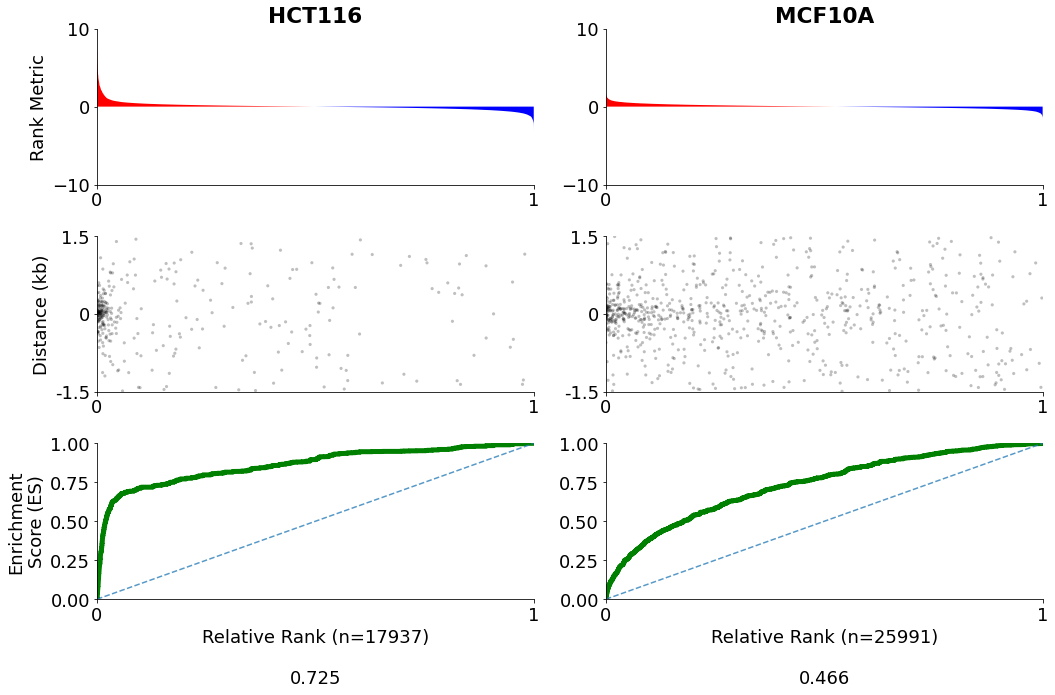

/Users/joru1876/TFEA_Jupyter/Figures/Supp_Nutlin_Method_Comparison_TFEA.pdf

In [15]:
def fasta_names(fastafile=None):
    names = list()
    with open(fastafile) as F:
        for line in F:
            if line[0] == '>':
                names.append(line[1:].strip('\n'))
    
    return names

def heatmap(distances, ax=None, xlim=None, bins=None, title=None, 
            largewindow=None, cmap='', smallwindow=150, horizontal=False):
    distances = [x for x in distances if x != '.']
    counts, edges = np.histogram(distances, bins=bins)
    edges = (edges[1:]+edges[:-1])/2.0
    norm    = matplotlib.colors.Normalize(vmin=min(counts), 
                                            vmax=max(counts))
    if cmap == 'blues':
        cmap    = cm.Blues
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'oranges':
        cmap    = cm.Oranges
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'reds':
        cmap    = cm.Reds
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    elif cmap == 'greens':
        cmap    = cm.Greens
        m       = cm.ScalarMappable(norm=norm, cmap=cmap)
        colors  = [m.to_rgba(c) for c in counts] 
    
    if horizontal:
        ax.barh(edges,(edges[-1]-edges[0])/len(edges), height=np.ones((len(edges),)), 
               color=colors, edgecolor=colors)
        
        ax.tick_params(axis='x', which='both', bottom=False, top=False, 
                        labelbottom=False) 
        ax.tick_params(axis='y', which='both', left=True, right=False, 
                        labelleft=True)
        md = len([x for x in distances if x < 150 and x !='.'])/len([x for x in distances if x != '.'])
        ax.set_ylabel(f'Distance (kb)\n\n{str("%.3g" % md)}')
        ax.set_yticks([-largewindow, 0, largewindow])
        ax.set_yticklabels([str(-largewindow/1000), 0, str(largewindow/1000)])
    else:
        ax.bar(edges,np.ones((len(edges),)), color=colors, 
                width=(edges[-1]-edges[0])/len(edges), edgecolor=colors)
        ax.set_ylim([0,1])
        ax.set_xlim([-largewindow, largewindow])
#     ax.axvline(-smallwindow, linestyle='--', c='k', alpha=0.5)
#     ax.axvline(smallwindow, linestyle='--', c='k', alpha=0.5)
        ax.tick_params(axis='y', which='both', left=False, right=False, 
                        labelleft=False) 
        ax.tick_params(axis='x', which='both', bottom=True, top=False, 
                        labelbottom=True)
        md = len([x for x in distances if abs(x) < 150])/len(distances)
        ax.set_xlabel(f'Distance (kb)\n\n{str("%.3g" % md)}')
        ax.set_xticks([-largewindow, 0, largewindow])
        ax.set_xticklabels([str(-largewindow/1000), 0, str(largewindow/1000)])
    if title is not None:
        ax.set_title(title)
    for spine in ax.spines:
        ax.spines[spine].set_visible(False)
    return

def parse_fimo_venn(fimo_res1, fimo_res2):
    overlap1 = []
    overlap2 = []
    intersect = []
    heatmap1 = {}
    heatmap2 = {}
    venn = [0 for i in range(3)]

    for line1 in fimo_res1[2:]:
        line1_list = line1.split('\t')
        region1 = line1_list[2]
        start1,stop1 = region1.split(':')[1].split('-')
        start1,stop1 = int(start1),int(stop1)
        score1 = float(line1_list[6])
        motif1_distance = np.mean([int(line1_list[3]), int(line1_list[4])]) - largewindow
        if region1 not in heatmap1:
            heatmap1[region1] = [score1, motif1_distance]
        elif score1 > heatmap1[region1][0]:
            heatmap1[region1] = [score1, motif1_distance]
            
    for line2 in fimo_res2[2:]:
        line2_list = line2.split('\t')
        region2 = line2_list[2]
        start2,stop2 = region2.split(':')[1].split('-')
        start2,stop2 = int(start2),int(stop2)
        score2 = float(line2_list[6])
        motif = int(start2) + np.mean([int(line2_list[3]), int(line2_list[4])])
        motif2_distance = np.mean([int(line2_list[3]), int(line2_list[4])]) - largewindow
        if region2 not in heatmap2:
            heatmap2[region2] = [score2, motif2_distance]
        elif score2 > heatmap2[region2][0]:
            heatmap2[region2] = [score2, motif2_distance]
            
            
    for region1 in heatmap1:
        chrom1 = region1.split(':')[0]
        start1,stop1 = region1.split(':')[1].split('-')
        start1,stop1 = int(start1),int(stop1)
        motif1_distance = heatmap1[region1]
        for region2 in heatmap2:
            chrom2 = region2.split(':')[0]
            start2,stop2 = region2.split(':')[1].split('-')
            start2,stop2 = int(start2),int(stop2)
            motif2_distance = heatmap2[region2]
            if chrom1 == chrom2 and (start1 <= start2 <= stop1 or start1 <= stop2 <= stop1):
                if abs(motif1_distance[1]) < 150 or abs(motif2_distance[1]) < 150:
                    overlap1.append(region1)
                    overlap2.append(region2)
                    #muMerge here?
                    i_start = min(start1, start2)
                    i_stop = max(stop1, stop2)
                    i_mid = np.mean([i_start, i_stop])
                    i_motif_distance = motif - i_mid
    #                 intersect.append(i_motif_distance)

#     heatmap1 = [d for i,d in enumerate(heatmap1) if i not in overlap1]
#     heatmap2 = [d for i,d in enumerate(heatmap2) if i not in overlap2]
    overlap1 = list(set(overlap1))
    overlap2 = list(set(overlap2))
    venn[2] = max(len(overlap1), len(overlap2))
    venn[0] = len([region for region in heatmap1 if region not in overlap1 and abs(heatmap1[region][1]) < 150])
    venn[1] = len([region for region in heatmap2 if region not in overlap2 and abs(heatmap2[region][1]) < 150])
    
    return [v[1] for v in heatmap1.values()], [v[1] for v in heatmap2.values()], venn

def parse_fimo(fimo_stdout=None, largewindow=None, retain='score', 
                        names=None):
    d = dict()
    lines = fimo_stdout
    header = lines[1].split('\t')
    max_score = 0
    if len(header) > 1:
        start_index = header.index('start')
        stop_index = header.index('stop')
        name_index = header.index('sequence_name')
        score_index = header.index('score')
    for item in lines[2:-1]: #To remove header and empty last line in output
        line_list = item.split('\t')
        id = line_list[name_index]
        start = line_list[start_index]
        stop = line_list[stop_index]
        distance = ((int(start)+int(stop))/2)-int(largewindow)
        score = float(line_list[score_index])
        if id not in d:
            d[id] = [score, distance]
        else:
            prev_score = d[id][0]
            if prev_score < score:
                d[id] = [score, distance]

    distances = [] 
    for name in names:
        if name in d:
            distances.append(d[name][1])
        else:
            distances.append('.')

    return distances

def deseq_parse(deseq_file, basemean_cut=0):
    #Parse the DE-Seq output file
    up = list()
    down = list()
    with open(deseq_file) as F:
        header = F.readline().strip('\n').split('\t')
        fc_index = [i for i in range(len(header)) 
                    if header[i]=='"fc"' or header[i]=='"foldChange"'][0]
        basemean_index = [i for i in range(len(header)) if header[i]=='"baseMean"'][0]
        for line in F:
            line = line.strip('\n').split('\t')
            if line[fc_index+1] != 'NA':
                try:
                    pval = format(float(line[-2]),'.12f')
                except ValueError:
                    pval = format(1.0,'.12f')
                region = line[0].split(':')
                chrom = region[0]
                coordinates = region[1].split('-')
                start = coordinates[0]
                stop = coordinates[1]
                chrom = chrom.strip('"')
                stop = stop.strip('"')
                center = int((int(start)+int(stop))/2)
                start = center - int(largewindow)
                start = start if start > 0 else 0
                stop = center + int(largewindow)
                fc = float(line[fc_index+1])
                basemean = float(line[basemean_index+1])
                if basemean > basemean_cut:
                    if fc < 1:
                        down.append([chrom, str(start), str(stop), str(fc), str(pval)])
                    else:
                        up.append([chrom, str(start), str(stop), str(fc), str(pval)])
    #Save ranked regions in a bed file (pvalue included)
    pvals = list()
    fcs = list()
    for region in sorted(up, key=lambda x: x[4]):
        pvals.append(float(region[-1]))
        fcs.append(float(region[3]))
    for region in sorted(down, key=lambda x: x[4], reverse=True):
        pvals.append(float(region[-1]))
        fcs.append(float(region[3]))
        
    logpval = list()
    for x,y in zip(pvals,fcs):
        try:
            if y < 1:
                logpval.append(math.log(x,10))
            else:
                logpval.append(-math.log(x,10))
        except:
            logpval.append(0.0)

    return logpval, pvals

def enrichment_calculate_plot(distances, **kwargs):
    nan = float('Nan')
    distances_abs = [abs(x)  if x != '.' else x for x in distances]

    hits = len([x for x in distances_abs if x != '.'])

    #Get -exp() of distance and get cumulative scores
    #Filter distances into quartiles to get middle distribution
    q1 = int(round(len(distances)*.25))
    q3 = int(round(len(distances)*.75))
    middledistancehist =  [x for x in distances_abs[int(q1):int(q3)] if x != '.']
    average_distance = np.mean(middledistancehist)
    score = [math.exp(-float(x)/average_distance) if x != '.' else 0.0 for x in distances_abs]
    total = np.sum(score)

    binwidth = 1.0/float(len(distances_abs))
    normalized_score = np.multiply(np.divide(score, total), binwidth)
    cumscore = np.cumsum(normalized_score)
    trend = np.append(np.arange(0,1,1.0/float(len(cumscore) - 1)), 1.0)
    trend = np.multiply(trend, binwidth)

    #The AUC is the relative to the "random" line
    auc = np.trapz(cumscore) - np.trapz(trend)
    auc = auc*2
    plotting_score = np.divide(score, total)
    # [(float(x)/total) for x in score]
    plotting_cumscore = np.cumsum(plotting_score)
    lineplot(yvals=plotting_cumscore, auc=auc, **kwargs)
    
def lineplot(title=None, ax=None, xvals=None, yvals=None, xlimits=None, auc=0):
    #This is the enrichment score plot (i.e. line plot)
    ax.plot(xvals,yvals,color='green',linewidth=5)
    ax.plot([0, 1],[0, 1], '--', alpha=0.75)
    fill_between_trend = np.linspace(start=0, stop=1, num=len(xvals))
#     ax.fill_between(xvals, fill_between_trend, yvals, facecolor='red', zorder=10)
    ax.set_title(title)
    ax.set_ylabel('Enrichment\nScore (ES)')
#     ax.tick_params(axis='y', which='both', left=True, right=False, 
#                     labelleft=True)
#     ax.tick_params(axis='x', which='both', bottom=False, top=False, 
#                     labelbottom=False)
    ax.set_ylim([0,1])
    ax.set_xlim(xlimits)
    ax.set_xticks([0,1])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_xlabel(f'Relative Rank (n={len(xvals)})\n\n{str("%.3g" % auc)}')
    return

def scatterplot(ax=None, xvals=None, yvals=None, xlimits=None, largewindow=None, 
                xlabel=False, axvline=0.2):
    #This is the barplot right below the enrichment score line plot
    ax.scatter(xvals, yvals, edgecolor="", color="black", 
                    s=10, alpha=0.25)
    if axvline:
        ax.set_xticks([0,axvline, 1])
        ax.set_xticklabels(['0','','1'])
        ax.axvline(axvline, linestyle='--', c='k', linewidth=2, alpha=0.5)
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0','1'])
    ax.set_yticks([-int(largewindow),0,int(largewindow)])
    ax.set_yticklabels([str(largewindow/-1000.0), '0', str(largewindow/1000.0)])
    ax.set_xlim(xlimits)
    ax.set_ylim([-int(largewindow),int(largewindow)])
    ax.set_ylabel('Distance (kb)')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def fillplot(ax=None, xvals=None, yvals=None, xlimits=[0,1], ylimits=None, axvline=0.2):
    #This is the rank metric fill plot
    posvals = [(x,y) for x,y in zip(xvals,yvals) if y > 0]
    negvals = [(x,y) for x,y in zip(xvals,yvals) if y < 0]
    ax.fill_between([x for x,_ in posvals], 0, [y for _,y in posvals],facecolor='red',edgecolor="")
    ax.fill_between([x for x,_ in negvals], 0, [y for _,y in negvals],facecolor='blue',edgecolor="")
    if ylimits is None:
        ylim = math.fabs(max([x for x in yvals if -500 < x < 500],key=abs))
        ax.set_yticks([int(-ylim), 0, int(ylim)])
        ax.set_ylim([int(-ylim), 0, int(ylim)])
    else:
        ax.set_yticks([ylimits[0], 0, ylimits[1]])
        ax.set_ylim(ylimits)
    if axvline:
        ax.set_xticks([0,0.2, 1])
        ax.set_xticklabels(['0','0.2','1'])
        ax.axvline(0.2, linestyle='--', c='k', linewidth=2, alpha=0.5)
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0','1'])
    ax.set_xlim(xlimits)
    ax.set_ylabel('Rank Metric')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def mdd_fillplot(ax=None, xvals=None, yvals=None, xlimits=[0,1], ylimits=None, axvline=0.2):
    #This is the rank metric fill plot
#     ax.fill_between(xvals, 0, yvals ,facecolor='red',edgecolor="")
    ax.plot(xvals,yvals,c="r")
    ax.axhline(0, c='r')
    if ylimits is None:
        ylim = math.fabs(max([x for x in yvals if -500 < x < 500], key=abs))
        ax.set_yticks([int(-ylim), 0, int(ylim)])
        ax.set_ylim([int(-ylim), 0, int(ylim)])
    else:
        ax.set_yticks([ylimits[0], 0, ylimits[1]])
        ax.set_ylim(ylimits)
    if axvline:
        ax.set_xticks([0, axvline, 1])
        ax.set_xticklabels(['0','','1'])
        ax.text(axvline, 2, ' DE-Seq p-val 0.2', horizontalalignment='left')
        ax.axvline(axvline, linestyle='--', c='k', linewidth=2, alpha=0.5)
    else:
        ax.set_xticks([0, 1])
        ax.set_xticklabels(['0', '1'])
    ax.set_xlim(xlimits)
    ax.set_ylabel('$-log_{10}$(DE-Seq p-value)', fontsize=14)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

#=============================================================

largewindow = 1500

Allen_deseq = '/Users/joru1876/TFEA_files/Allen2014/v5_output/20191204_DMSO_Nutlin_bugfix/temp_files/DESeq.res.txt'
Allen_fasta = '/Users/joru1876/TFEA_files/Allen2014/v5_output/20191204_DMSO_Nutlin_bugfix/temp_files/ranked_file.fa'
Levandowski_deseq = '/Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/DESeq.res.txt'
Levandowski_fasta = '/Users/joru1876/TFEA_files/CECIE/7_WT_DMSO_Nutlin_1hr_mumerge/temp_files/ranked_file.fa'

Allen_heatmap1, Allen_heatmap2, Allen_venn = parse_fimo_venn(Allen_md1_fimo, Allen_md2_fimo)
Levandowski_heatmap1, Levandowski_heatmap2, Levandowski_venn = parse_fimo_venn(Levandowski_md1_fimo, Levandowski_md2_fimo)
Levandowski_venn_sum = np.sum(Levandowski_venn)
Allen_venn_sum = np.sum(Allen_venn)
Allen_fasta_regions = fasta_names(fastafile=Allen_fasta)
Levandowski_fasta_regions = fasta_names(fastafile=Levandowski_fasta)
Allen_distances = parse_fimo(fimo_stdout=Allen_combined_fimo, largewindow=largewindow, 
                                names=Allen_fasta_regions)
Levandowski_distances = parse_fimo(fimo_stdout=Levandowski_combined_fimo, largewindow=largewindow, 
                                names=Levandowski_fasta_regions)

F = plt.figure(figsize=(15,10))
outer = gridspec.GridSpec(3, 2, height_ratios=[1,1,1])
i = 0


#TFEA HCT116 rank fillplot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
Allen_logpval, _ = deseq_parse(Allen_deseq)
xvals = np.linspace(start=0, stop=1, num=len(Allen_logpval))
ax = F.add_subplot(inner[0])
fillplot(ax=ax, xvals=xvals, yvals=Allen_logpval, xlimits=[0, 1], ylimits=[-10,10], axvline=False)
ax.set_title('HCT116', fontweight='bold')
i+=1



#TFEA MCF10A rank fillplot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
Levandowski_logpval, _ = deseq_parse(Levandowski_deseq)
xvals = np.linspace(start=0, stop=1, num=len(Levandowski_logpval))
ax = F.add_subplot(inner[0])
fillplot(ax=ax, xvals=xvals, yvals=Levandowski_logpval, xlimits=[0, 1], ylimits=[-10,10], axvline=False)
ax.set_ylabel('')
ax.set_title('MCF10A', fontweight='bold')
i+=1


#TFEA HCT116 Scatterplot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
ax2 = F.add_subplot(inner[0])
xvals = np.linspace(start=0, stop=1, num=len(Allen_distances))
scatter_data = [(i,x) for i,x in zip(xvals, Allen_distances) if x != '.']
scatter_x = [i for i,_ in scatter_data]
scatter_y = [x for _,x in scatter_data]
scatterplot(ax=ax2, xvals=scatter_x, yvals=scatter_y, xlimits=[0,1], largewindow=largewindow, 
                xlabel=False, axvline=False)
i+=1


#TFEA MCF10A Scatterplot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
ax2 = F.add_subplot(inner[0])
xvals = np.linspace(start=0, stop=1, num=len(Levandowski_distances))
scatter_data = [(i,x) for i,x in zip(xvals, Levandowski_distances) if x != '.']
scatter_x = [i for i,_ in scatter_data]
scatter_y = [x for _,x in scatter_data]
scatterplot(ax=ax2, xvals=scatter_x, yvals=scatter_y, xlimits=[0,1], largewindow=largewindow, 
                xlabel=False, axvline=False)
ax2.set_ylabel('')
i+=1


#HCT116 Enrichment Plot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
ax = F.add_subplot(inner[0])
xvals = np.linspace(start=0, stop=1, num=len(Allen_distances))
enrichment_calculate_plot(Allen_distances, xvals=xvals, xlimits=[0,1], ax=ax)
i+=1


#MCF10A Enrichment Plot
inner = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=outer[i])
ax = F.add_subplot(inner[0])
xvals = np.linspace(start=0, stop=1, num=len(Levandowski_distances))
enrichment_calculate_plot(Levandowski_distances, xvals=xvals, xlimits=[0,1], ax=ax)
ax.set_ylabel('')
i+=1


outer.tight_layout(F)
figname = os.path.join(figuredir, 'Supp_Nutlin_Method_Comparison_TFEA.pdf')
F.savefig(figname, bbox_inches='tight', format='pdf', transparent=True)
plt.show()
FileLink(str(Path(figname).relative_to(Path.cwd())))